In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# 배경
주어진 데이터와 관련해 해결 가능한 문제를 찾기 위해 최근 기사를 살펴보던 중, 넷플릭스의 수익적 열세에 관한 기사를 다수 발견할 수 있었다. 열세 속에서 넷플릭스의 수익률을 끌어올릴 수 있는 방법을 찾기 위해 다른 ott 서비스를 함께 분석했다. 분석 전 세운 가설은 다음과 같다.

1. 특정 장르가 강한 플랫폼의 경우 이용자 확보가 더 용이하기 때문에 수익성에도 긍정적인 영향을 미칠 것이다.
2. 특정 나이대의 타겟층을 가진 플랫폼의 경우 이용자 확보가 용이하기 때문에 수익성 측면에서도 긍정적이다.

 주어진 기본 데이터 네 가지에서는 각 플랫폼의 장르와 수익성, 특정 시청 연령과 수익성 사이 상관관계는 파악할 수 없다. 따라서 수익성과 관계성까지 모두 파악하지 못하더라도, 장르, 시청 연령을 비롯해 다양한 feature와 관련한 기본적인 EDA를 진행하고자 한다.

# Netflix EDA

## Loading the dataset

In [2]:
net_basic = pd.read_csv('./netflix_titles.csv')
net_basic.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


rating의 정보가 알아보기 어려우므로 target_ages라는 column을 추가해준다.
- [참고: Netflix Data Visualization - Target Ages](https://www.kaggle.com/joshuaswords/netflix-data-visualization)

In [3]:
# target_ages 추가
def add_target_ages(df):
    rating_ages = {
        'TV-PG': 'Older Kids',
        'TV-MA': 'Adults',
        'TV-Y7-FV': 'Older Kids',
        'TV-Y7': 'Older Kids',
        'TV-14': 'Teens',
        'R': 'Adults',
        'TV-Y': 'Kids',
        'NR': 'Adults',
        'PG-13': 'Teens',
        'TV-G': 'Kids',
        'PG': 'Older Kids',
        'G': 'Kids',
        'UR': 'Adults',
        'NC-17': 'Adults'
    }
    df['target_ages'] = df['rating'].replace(rating_ages)
    
    return df['target_ages']

add_target_ages(net_basic)

0            Teens
1           Adults
2           Adults
3           Adults
4           Adults
           ...    
8802        Adults
8803    Older Kids
8804        Adults
8805    Older Kids
8806         Teens
Name: target_ages, Length: 8807, dtype: object

In [4]:
net_basic.count()

show_id         8807
type            8807
title           8807
director        6173
cast            7982
country         7976
date_added      8797
release_year    8807
rating          8803
duration        8804
listed_in       8807
description     8807
target_ages     8803
dtype: int64

In [5]:
net_basic.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
target_ages        4
dtype: int64

결측치가 있는 것을 확인할 수 있었다. director와 cast의 경우 사용하지 않을 데이터기 때문에 크게 상관이 없고, date_added와 rating, duration에서 약간의 결측치가 확인되지만, 해당 열에 결측치가 있다고 해서 다른 열의 값이 무의미해지는 것은 아니기 때문에 여기선 df.dropna()와 같은 결측치 처리를 따로 하지 않을 것이다. 이후 각 열을 이용해 분석을 진행하는 데 있어 필요한 경우 결측치 처리를 할 것이다.

## Analysis based on Type

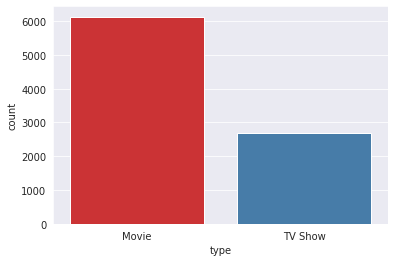

In [6]:
sns.set_style('darkgrid')
ax = sns.countplot(x="type", data=net_basic, palette="Set1")

In [7]:
net_tv = net_basic[net_basic['type']=='TV Show']

In [8]:
net_movie = net_basic[net_basic['type']=='Movie']

이후의 EDA는 모두 Movie, TV Show를 나누어 진행한다.

## Analysis based on Genre

In [9]:
#어떤 장르가 있는지 파악한 후 장르 수를 세기 위한 함수 선언
# genre_dict: 수가 많은 순서대로 반환
# genre_top10: 가장 많은 장르 10 개 반환
def get_info(data):
    data = list(map(lambda x: x.split(', '), list(data)))
    # 위의 결과가 이중리스트로 나오기 때문에 일차원 리스트로 바꿔줌
    data = list(itertools.chain(*data))
    data_count = Counter(data)
    
    data_sort = sorted(data_count.items(), key=lambda x: x[1], reverse=True)
    data_dict = {k: v for k, v in data_sort}
    data_top10 = {k: v for k, v in data_sort[:10]}
    return data, data_dict, data_top10

# 시각화
def show_genre(genre_dict, title, x_len=10, y_len=10, rotation=45):
    plt.figure(figsize=(x_len, y_len))
    x = list(genre_dict.keys())
    y = list(genre_dict.values())
    plt.vlines(x, ymin=0, ymax=y, color="gray")
    plt.plot(x, y, "o", color="green")
    plt.xticks(x, rotation = rotation)
    plt.ylabel("The Number of Contents", fontsize=15)
    plt.title(title, fontsize = 18)

### Movie

In [10]:
net_mg, net_mg_dict, net_mg_top10 = get_info(net_movie['listed_in'])

가장 많은 수의 장르: International Movies
가장 적은 수의 장르: Movies


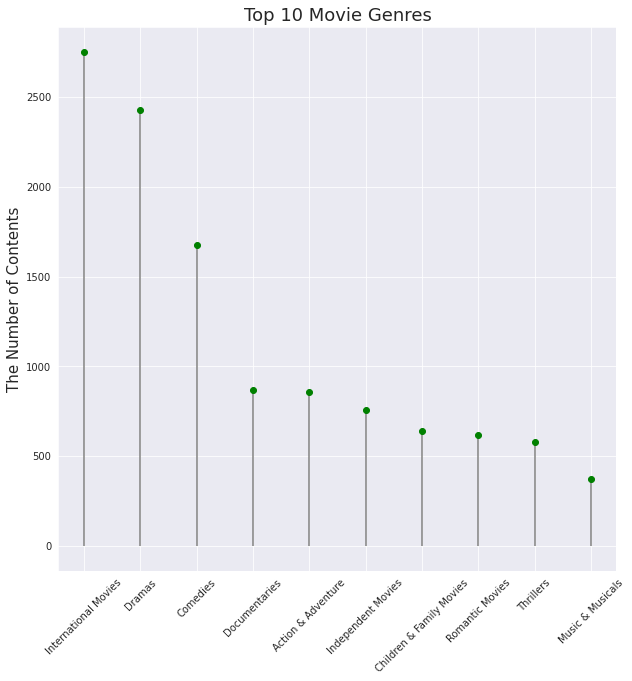

In [11]:
show_genre(net_mg_top10, "Top 10 Movie Genres")
print(f"가장 많은 수의 장르: {list(net_mg_dict.keys())[0]}\n가장 적은 수의 장르: {list(net_mg_dict.keys())[-1]}")

### TV Show

In [12]:
net_tg, net_tg_dict, net_tg_top10 = get_info(net_tv['listed_in'])

가장 많은 수의 장르: International TV Shows
가장 적은 수의 장르: TV Shows


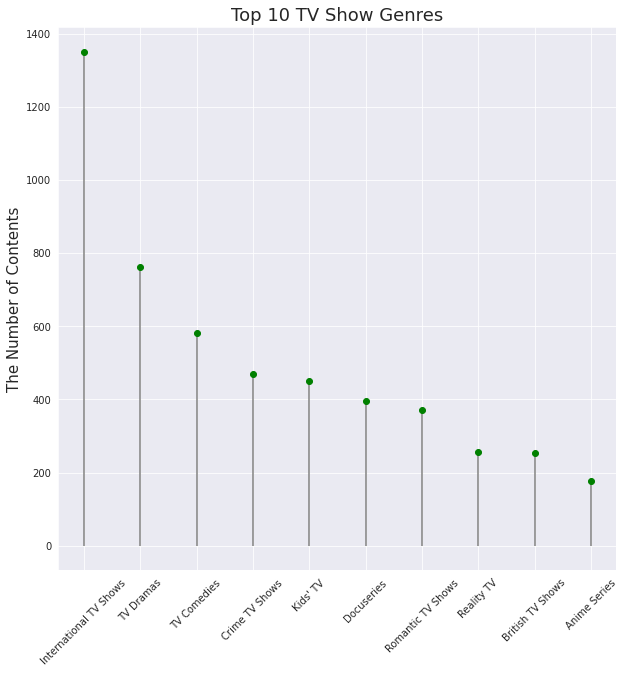

In [13]:
show_genre(net_tg_top10, "Top 10 TV Show Genres")
print(f"가장 많은 수의 장르: {list(net_tg_dict.keys())[0]}\n가장 적은 수의 장르: {list(net_tg_dict.keys())[-1]}")

## Analysis based on Rating

시청 연령을 기준으로 데이터의 수를 파악한다.

In [14]:
def show_column(data, data_col, col_name, n=10, k=0):
    plt.figure(figsize=(12, 10))
    sns.set(style='darkgrid')
    col_order = data_col.value_counts().index[0:n]
    ax = sns.countplot(x=col_name, data=data, palette="Set1", order=col_order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = k)

### Movie

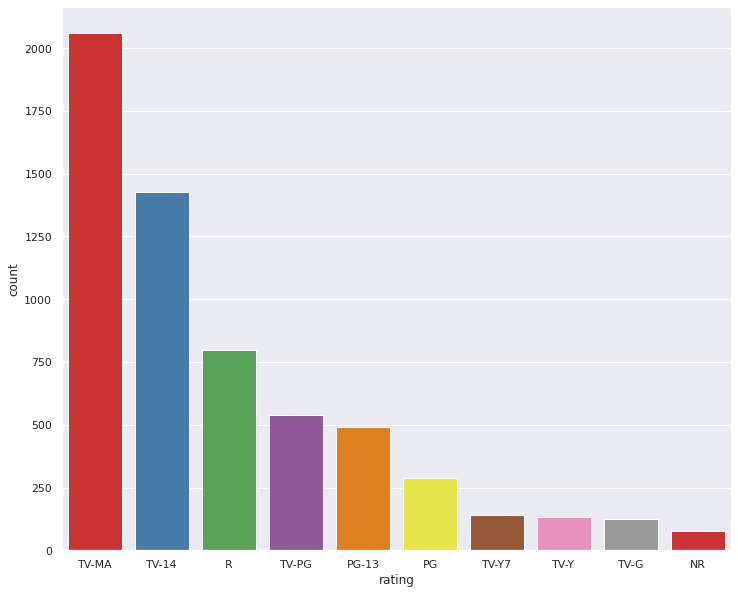

In [15]:
show_column(net_movie, net_movie['rating'], 'rating')

### TV show

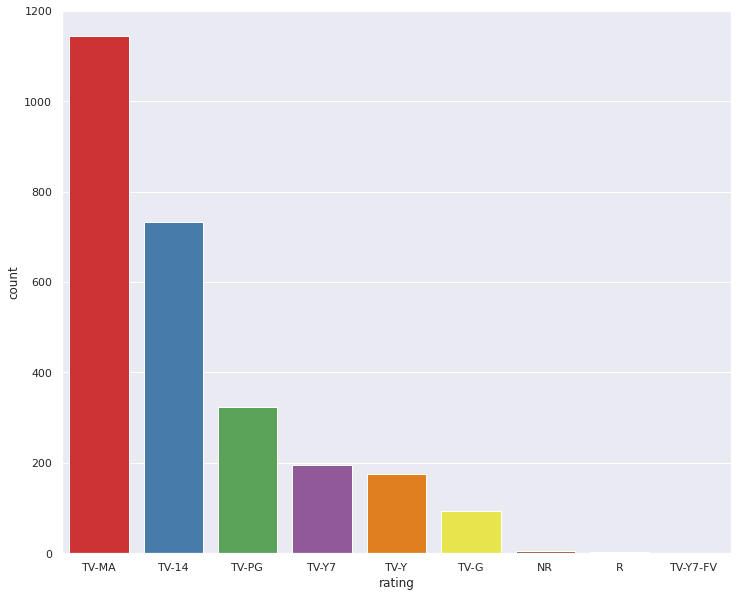

In [16]:
show_column(net_tv, net_tv['rating'], 'rating')

## Analysis based on Duration

방영 시간을 기준으로 데이터의 수를 파악한다.

In [17]:
def show_duration(duration):
    # 영화
    duration = duration.dropna()
    duration = duration.str.replace(' min', '')
    # TV show
    duration = duration.str.replace(' Seasons', '')
    duration = duration.str.replace(' Season', '')
    duration = duration.astype(str).astype(int)
    print(f"가장 짧은 경우: {min(duration)}\n가장 긴 경우: {max(duration)}")
    #시각화
    sns.set(style='darkgrid')
    sns.kdeplot(data=duration, shade=True)

가장 짧은 경우: 3
가장 긴 경우: 312


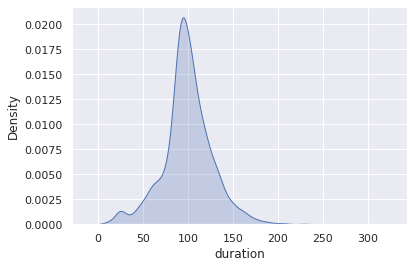

In [18]:
show_duration(net_movie['duration'])

가장 짧은 경우: 1
가장 긴 경우: 17


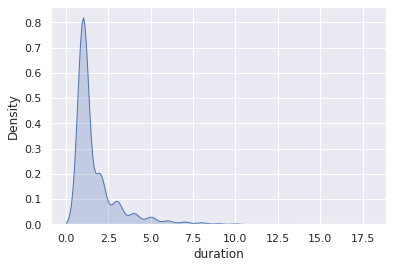

In [19]:
show_duration(net_tv['duration'])

## Analysis based on Year

### Movie

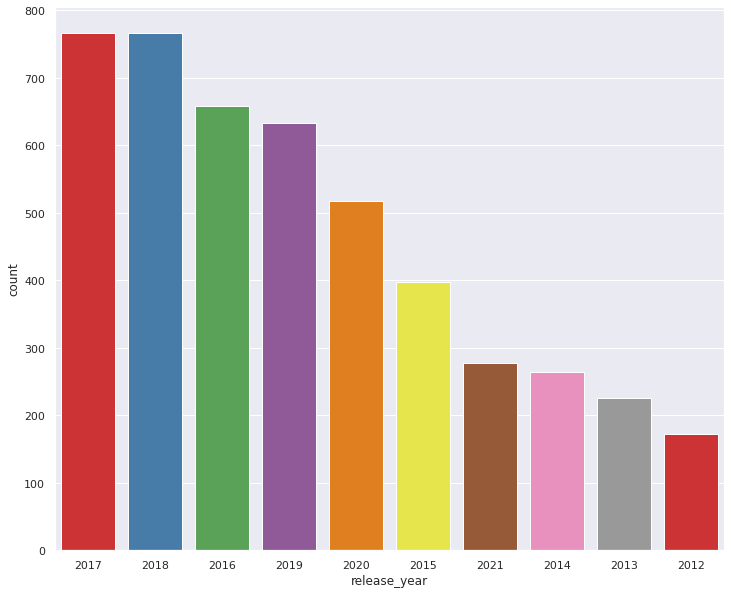

In [20]:
show_column(net_movie, net_movie['release_year'], 'release_year')

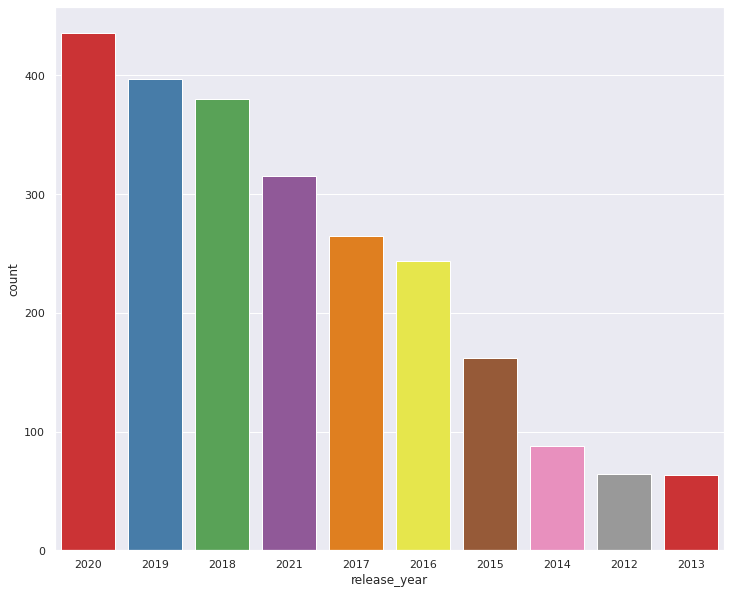

In [21]:
show_column(net_tv, net_tv['release_year'], 'release_year')

## Analysis based on Country

### Movie

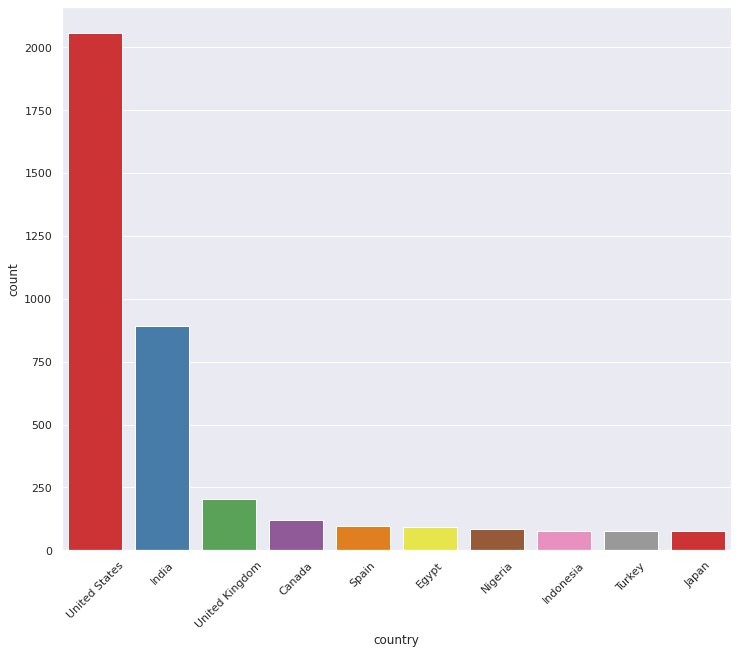

In [22]:
show_column(net_movie, net_movie['country'], 'country', 10, 45)

### TV show

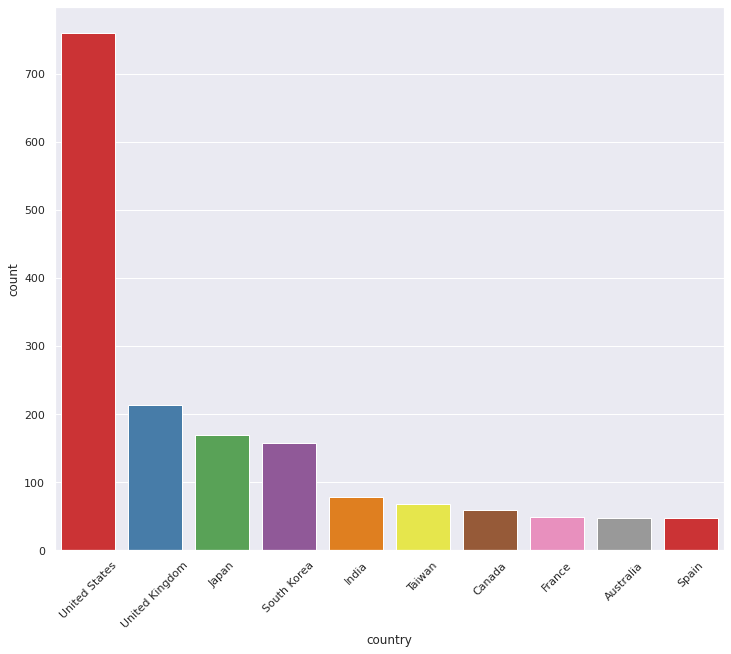

In [23]:
show_column(net_tv, net_tv['country'], 'country', 10, 45)

## Relation between Age and Genre

- [참고: Netflix Data Visualization - Target Ages](https://www.kaggle.com/joshuaswords/netflix-data-visualization)

위에선 한 컨텐츠에 여러 장르가 쓰여있을 경우 모두 고려했지만 여기서는 가장 먼저 쓰인 장르만을 고려했다.

In [24]:
def age_genre_heatmap(df, age_order=['Kids', 'Older Kids', 'Teens', 'Adults']):
    # listed_in에 여러 요소가 있는 경우 첫 번째 요소만 남김
    df['genre'] = df['listed_in'].apply(lambda x: x.split(',')[0])
    # 수를 세주기 위해 추가하는 column sum을 할 경우 특정 장르에 해당하는 컨텐츠의 총 수를 구할 수 있는 것.
    df['count'] = 1
    # genre, count를 선택
    # sum을 해서 각 genre의 수를 셈 (count가 더해지는 것)
    # 인덱스는 genre, 더해진 결과는 count에 저장됨.
    # 저장된 상태에서 count를 기준으로 정렬
    data = df.groupby('genre')[['genre', 'count']].sum().sort_values(by='count', ascending=False).reset_index()[:10]
    data = data['genre']
    # df에서 genre의 값이 data와 일치하는 것만 골라냄
    df_heatmap = df.loc[df['genre'].isin(data)]
    # crosstab을 사용해 빈도표 생성
    df_heatmap = pd.crosstab(df_heatmap['genre'], df_heatmap['target_ages'], normalize="index").T
    
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    genre_order = data.to_list()
    
    # heatmap 생성 - cbar: colorbar 유무, annot: 각 셀에 숫자 입력 여부, fmt: 자료형태 지정, vmax: 최대, vmin: 최소
    sns.heatmap(df_heatmap.loc[age_order, genre_order], square=True, linewidth=2.5, cbar=False, annot=True,fmt='1.0%',vmax=.6,vmin=0.05,ax=ax,annot_kws={"fontsize":12})

### Movie

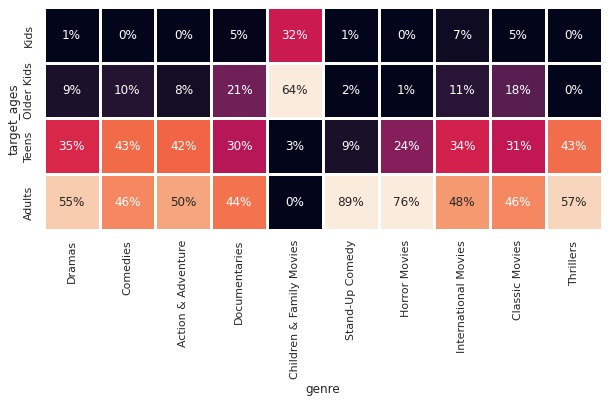

In [25]:
age_genre_heatmap(net_movie)

### TV Show

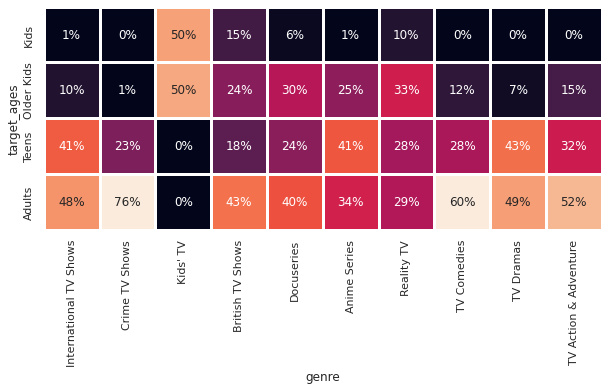

In [26]:
age_genre_heatmap(net_tv)

# Disney+ EDA

## Loading the dataset

In [27]:
dsny_basic = pd.read_csv('./disney_plus_titles.csv')
dsny_basic.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,"November 26, 2021",2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,"November 26, 2021",2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!"
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,"November 25, 2021",2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...


In [28]:
# ratings 변경
add_target_ages(dsny_basic)

0             Kids
1       Older Kids
2             Kids
3       Older Kids
4              NaN
           ...    
1445         Teens
1446    Older Kids
1447         Teens
1448         Teens
1449          Kids
Name: target_ages, Length: 1450, dtype: object

In [29]:
dsny_basic.count()

show_id         1450
type            1450
title           1450
director         977
cast            1260
country         1231
date_added      1447
release_year    1450
rating          1447
duration        1450
listed_in       1450
description     1450
target_ages     1447
dtype: int64

In [30]:
dsny_basic.isnull().sum()

show_id           0
type              0
title             0
director        473
cast            190
country         219
date_added        3
release_year      0
rating            3
duration          0
listed_in         0
description       0
target_ages       3
dtype: int64

## Analysis based on Type

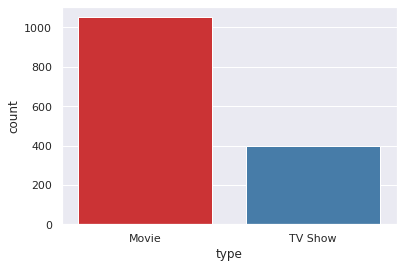

In [31]:
sns.set_style('darkgrid')
ax = sns.countplot(x="type", data=dsny_basic, palette="Set1")

In [32]:
dsny_tv = dsny_basic[dsny_basic['type']=='TV Show']

In [33]:
dsny_movie = dsny_basic[dsny_basic['type']=='Movie']

## Analysis based on Genre

### Movie

In [34]:
dsny_mg, dsny_mg_dict, dsny_mg_top10 = get_info(dsny_movie['listed_in'])

가장 많은 수의 장르: Family
가장 적은 수의 장르: Disaster


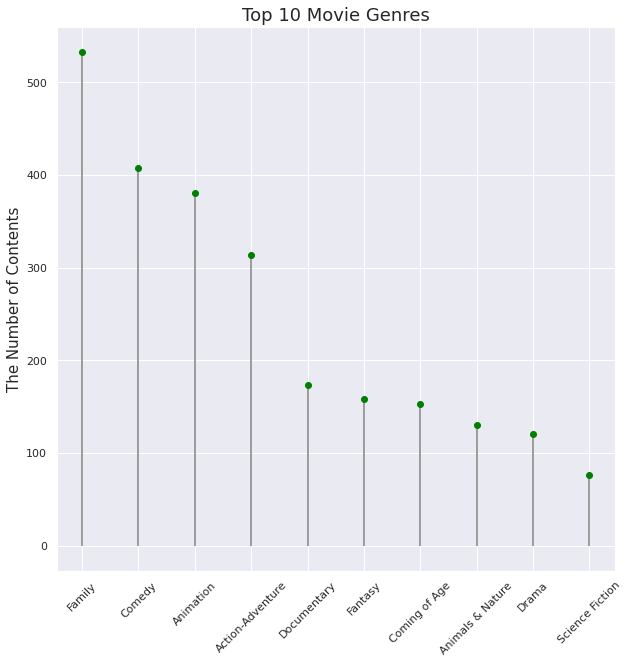

In [35]:
show_genre(dsny_mg_top10, "Top 10 Movie Genres")
print(f"가장 많은 수의 장르: {list(dsny_mg_dict.keys())[0]}\n가장 적은 수의 장르: {list(dsny_mg_dict.keys())[-1]}")

### TV Show

In [36]:
dsny_tg, dsny_tg_dict, dsny_tg_top10 = get_info(net_tv['listed_in'])

가장 많은 수의 장르: International TV Shows
가장 적은 수의 장르: TV Shows


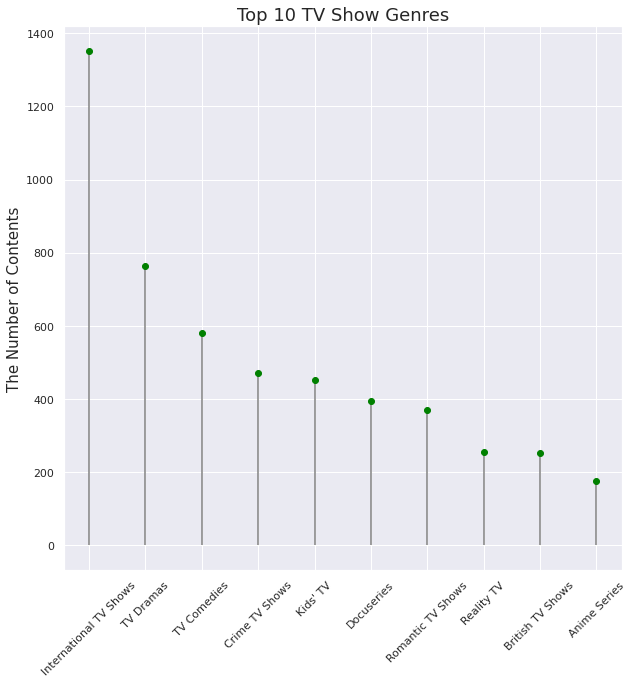

In [37]:
show_genre(dsny_tg_top10, "Top 10 TV Show Genres")
print(f"가장 많은 수의 장르: {list(dsny_tg_dict.keys())[0]}\n가장 적은 수의 장르: {list(dsny_tg_dict.keys())[-1]}")

## Analysis based on Rating

### Movie

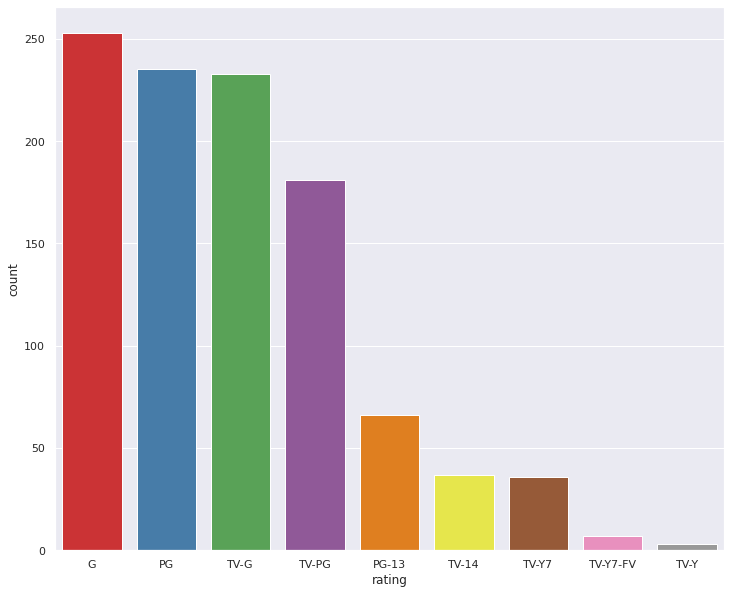

In [38]:
show_column(dsny_movie, dsny_movie['rating'], 'rating')

### TV show

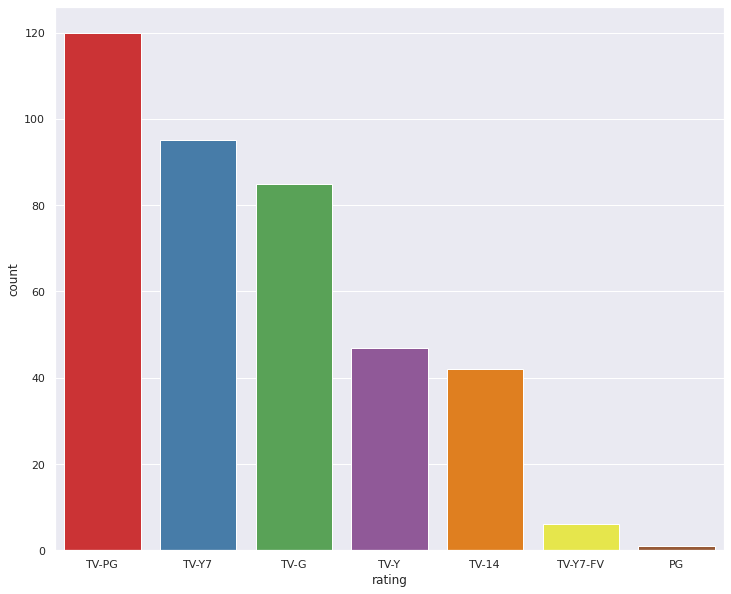

In [39]:
show_column(dsny_tv, dsny_tv['rating'], 'rating')

## Analysis based on Duration

가장 짧은 경우: 1
가장 긴 경우: 183


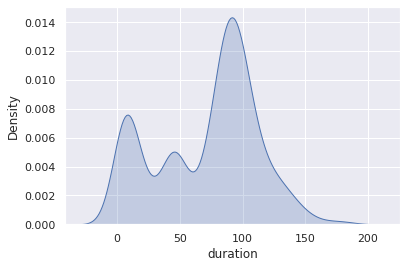

In [40]:
show_duration(dsny_movie['duration'])

가장 짧은 경우: 1
가장 긴 경우: 32


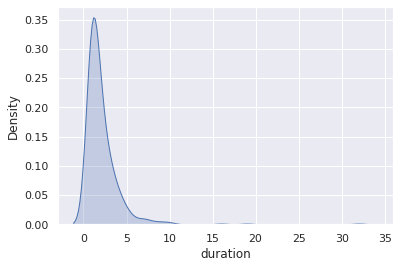

In [41]:
show_duration(dsny_tv['duration'])

## Analysis based on Year

### Movie

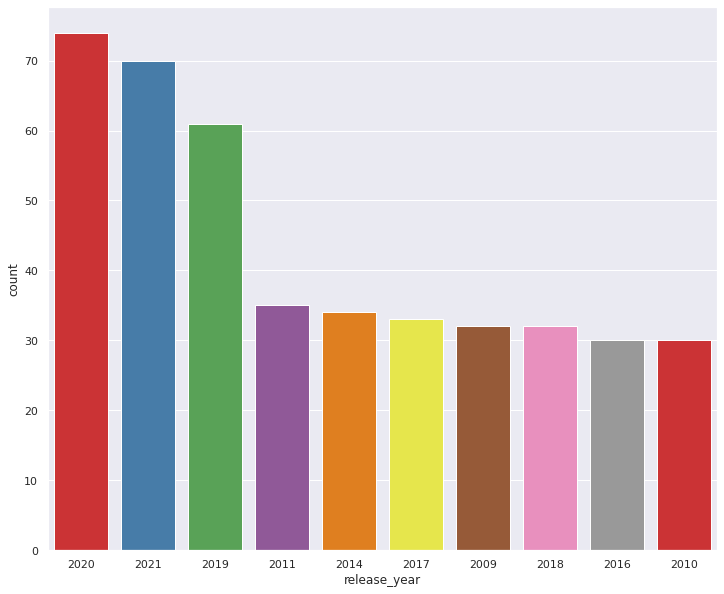

In [42]:
show_column(dsny_movie, dsny_movie['release_year'], 'release_year')

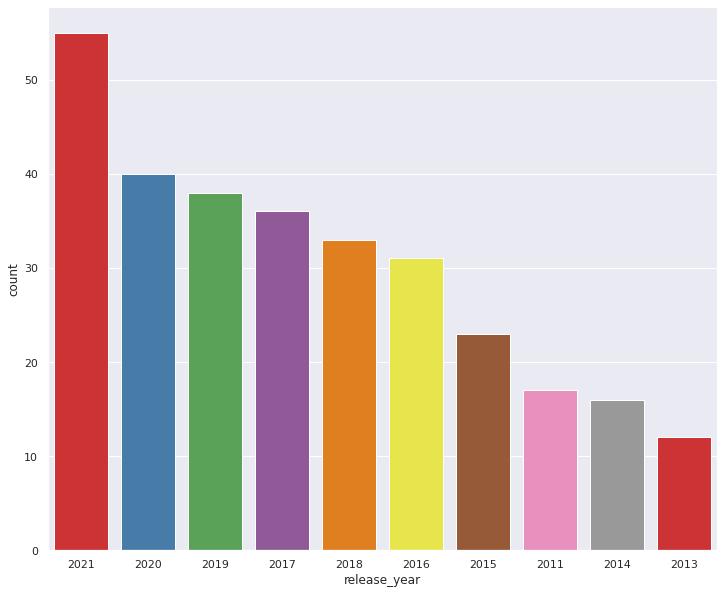

In [43]:
show_column(dsny_tv, dsny_tv['release_year'], 'release_year')

## Analysis based on Country

### Movie

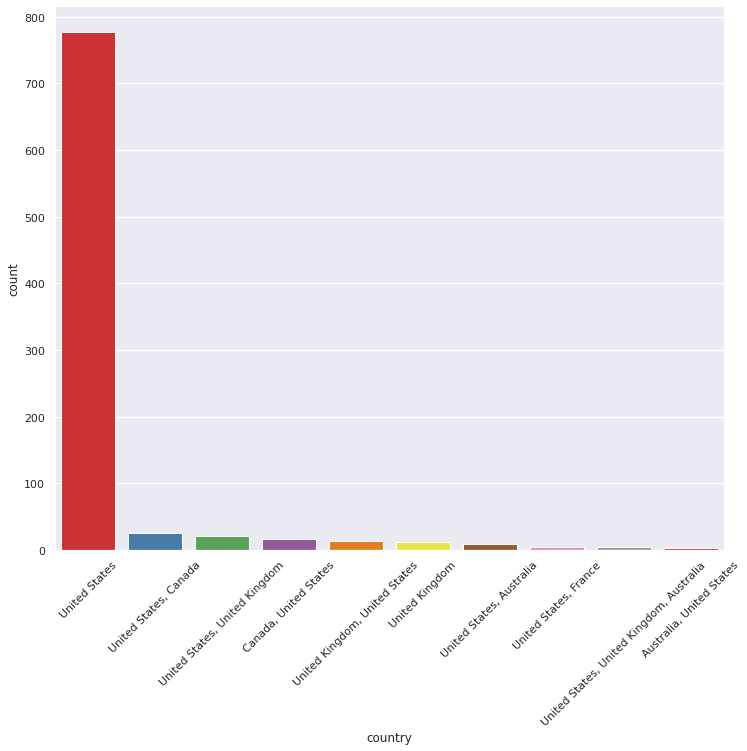

In [44]:
show_column(dsny_movie, dsny_movie['country'], 'country', 10, 45)

### TV show

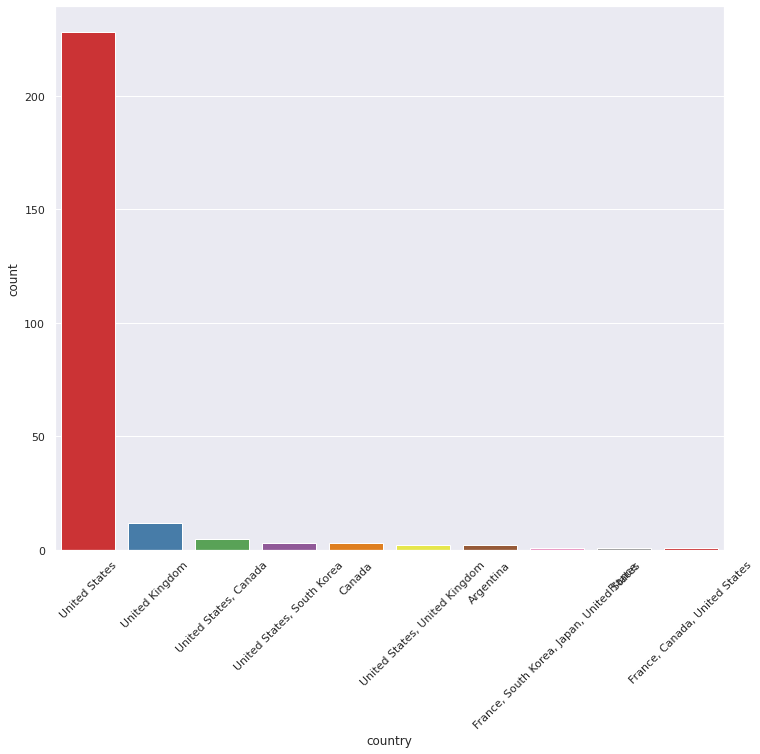

In [45]:
show_column(dsny_tv, dsny_tv['country'], 'country', 10, 45)

## Relation between Age and Genre

위에선 한 컨텐츠에 여러 장르가 쓰여있을 경우 모두 고려했지만 여기서는 가장 먼저 쓰인 장르만을 고려했다.

### Movie

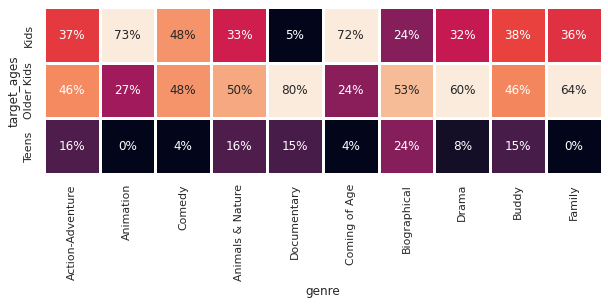

In [46]:
age_genre_heatmap(dsny_movie, ['Kids', 'Older Kids', 'Teens'])

### TV Show

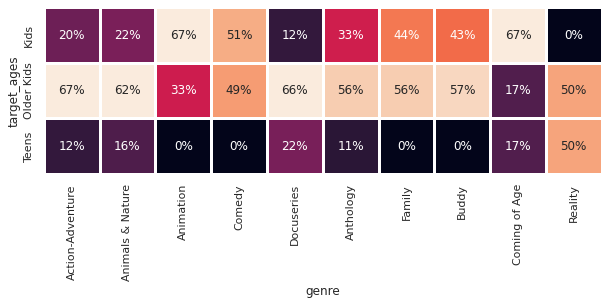

In [47]:
age_genre_heatmap(dsny_tv, ['Kids', 'Older Kids', 'Teens'])

# Amazon Prime Video EDA

## Loading the dataset

In [48]:
amz_basic = pd.read_csv('./amazon_prime_titles.csv')
amz_basic.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


In [49]:
# ratings 변경
add_target_ages(amz_basic)

0          NaN
1          13+
2          NaN
3          NaN
4          NaN
         ...  
9663        7+
9664       13+
9665    Adults
9666    Adults
9667    Adults
Name: target_ages, Length: 9668, dtype: object

In [50]:
amz_basic.count()

show_id         9668
type            9668
title           9668
director        7586
cast            8435
country          672
date_added       155
release_year    9668
rating          9331
duration        9668
listed_in       9668
description     9668
target_ages     9331
dtype: int64

In [51]:
amz_basic.isnull().sum()

show_id            0
type               0
title              0
director        2082
cast            1233
country         8996
date_added      9513
release_year       0
rating           337
duration           0
listed_in          0
description        0
target_ages      337
dtype: int64

## Analysis based on Type

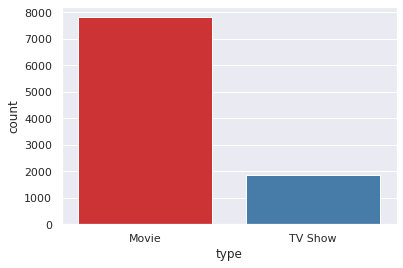

In [52]:
sns.set_style('darkgrid')
ax = sns.countplot(x="type", data=amz_basic, palette="Set1")

In [53]:
amz_tv = amz_basic[amz_basic['type']=='TV Show']

In [54]:
amz_movie = amz_basic[amz_basic['type']=='Movie']

## Analysis based on Genre

### Movie

In [55]:
amz_mg, amz_mg_dict, amz_mg_top10 = get_info(amz_movie['listed_in'])

가장 많은 수의 장르: Drama
가장 적은 수의 장르: Unscripted


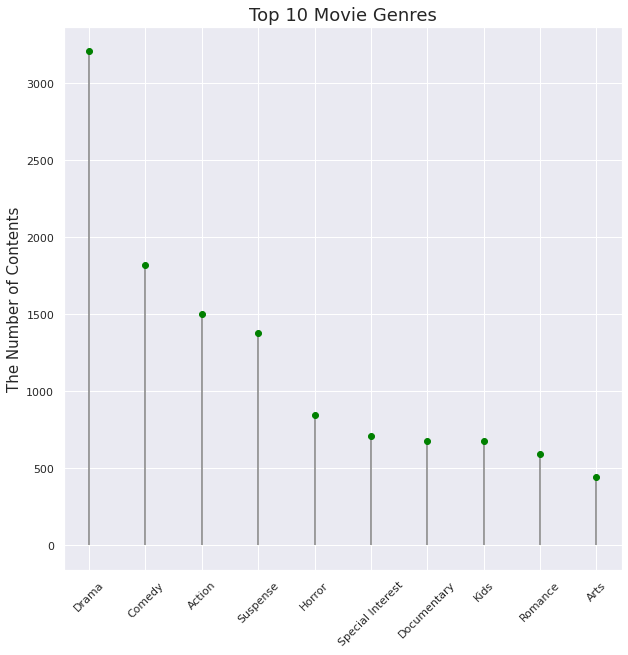

In [56]:
show_genre(amz_mg_top10, "Top 10 Movie Genres")
print(f"가장 많은 수의 장르: {list(amz_mg_dict.keys())[0]}\n가장 적은 수의 장르: {list(amz_mg_dict.keys())[-1]}")

### TV Show

In [57]:
amz_tg, amz_tg_dict, amz_tg_top10 = get_info(amz_tv['listed_in'])

가장 많은 수의 장르: Drama
가장 적은 수의 장르: Arthouse


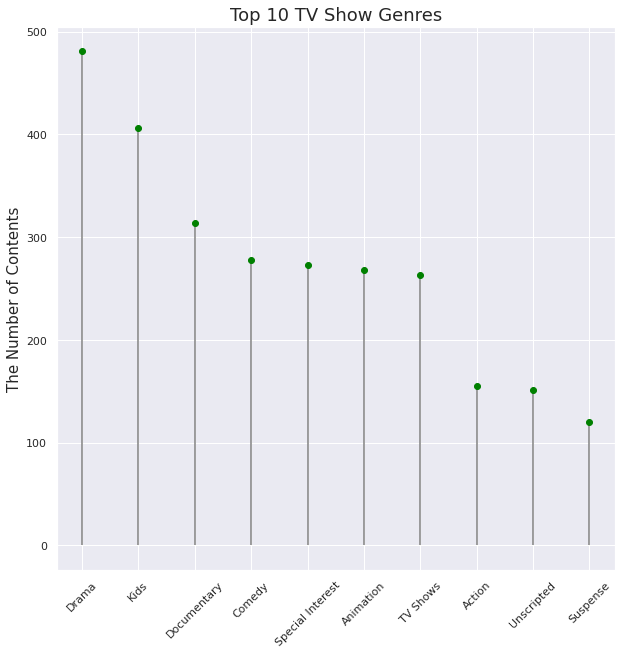

In [58]:
show_genre(amz_tg_top10, "Top 10 TV Show Genres")
print(f"가장 많은 수의 장르: {list(amz_tg_dict.keys())[0]}\n가장 적은 수의 장르: {list(amz_tg_dict.keys())[-1]}")

## Analysis based on Rating

### Movie

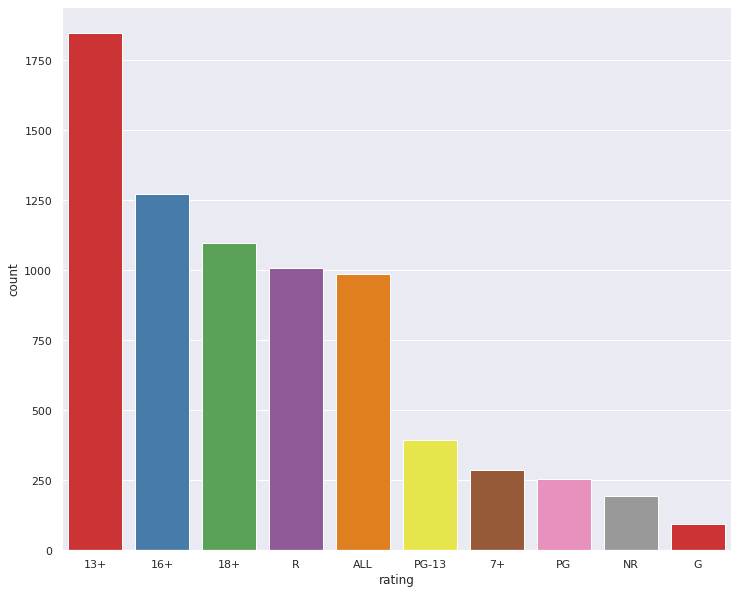

In [59]:
show_column(amz_movie, amz_movie['rating'], 'rating')

### TV show

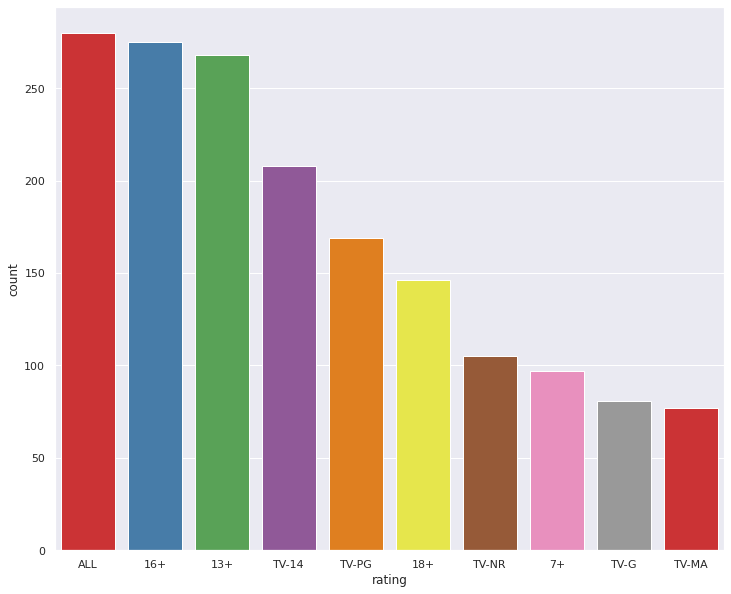

In [60]:
show_column(amz_tv, amz_tv['rating'], 'rating')

## Analysis based on Duration

가장 짧은 경우: 0
가장 긴 경우: 601


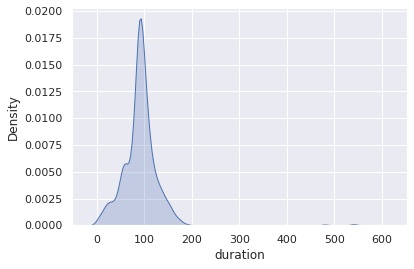

In [61]:
show_duration(amz_movie['duration'])

가장 짧은 경우: 1
가장 긴 경우: 29


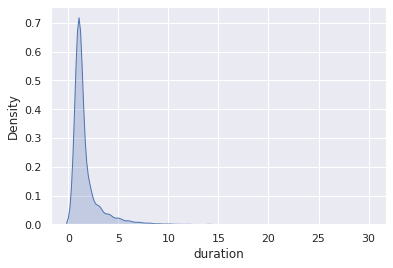

In [62]:
show_duration(amz_tv['duration'])

## Analysis based on Year

### Movie

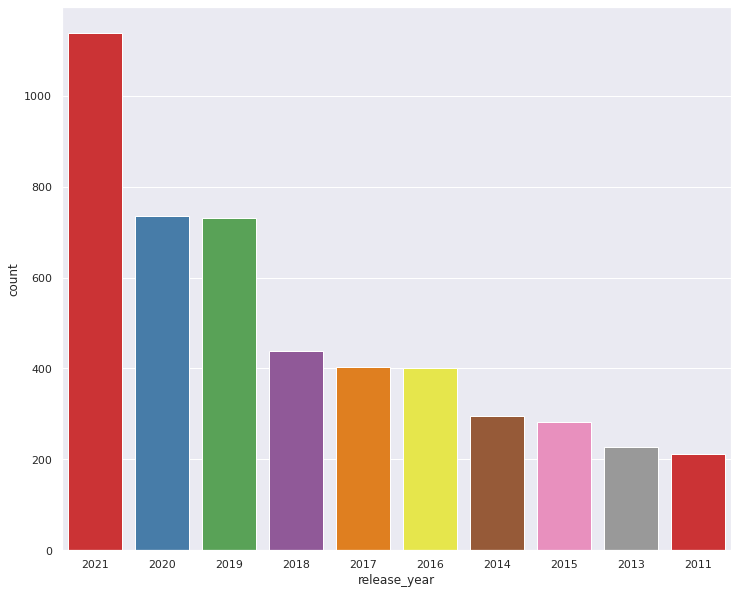

In [63]:
show_column(amz_movie, amz_movie['release_year'], 'release_year')

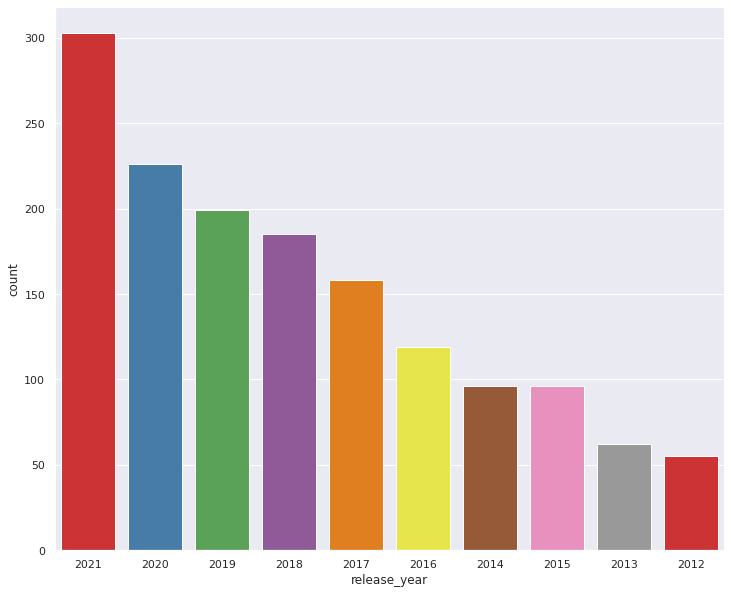

In [64]:
show_column(amz_tv, amz_tv['release_year'], 'release_year')

## Analysis based on Country

### Movie

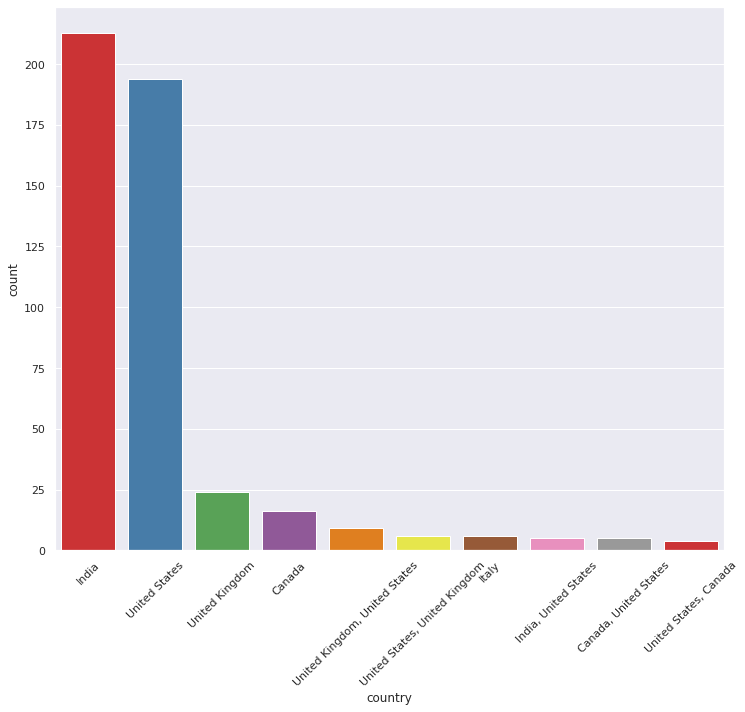

In [65]:
show_column(amz_movie, amz_movie['country'], 'country', 10, 45)

### TV show

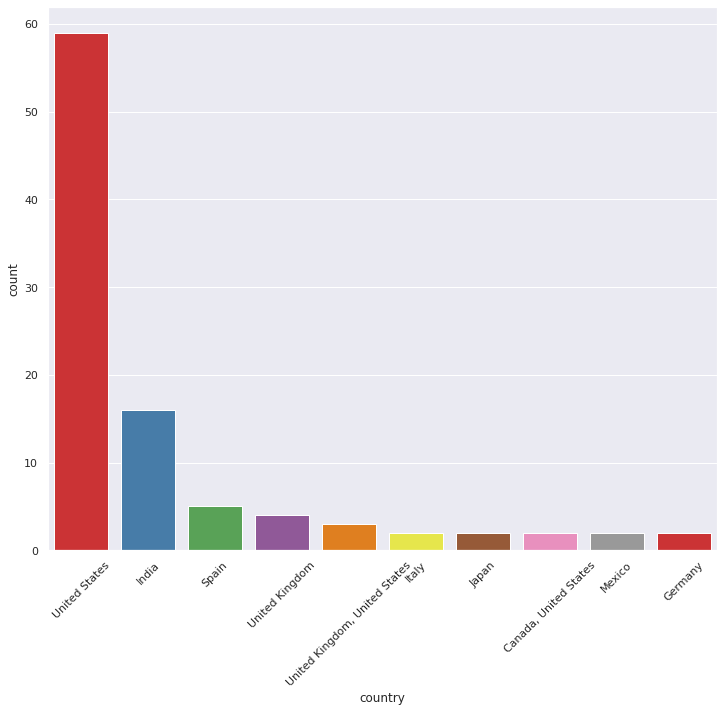

In [66]:
show_column(amz_tv, amz_tv['country'], 'country', 10, 45)

## Relation between Age and Genre

위에선 한 컨텐츠에 여러 장르가 쓰여있을 경우 모두 고려했지만 여기서는 가장 먼저 쓰인 장르만을 고려했다.

### Movie

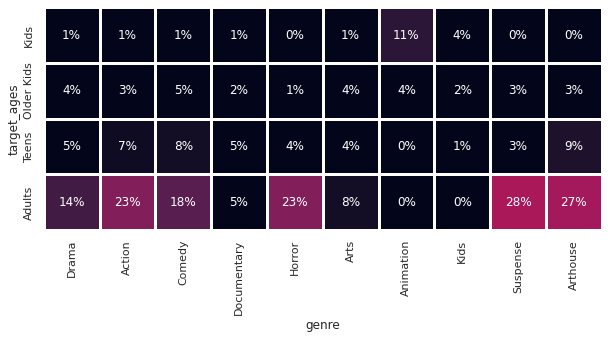

In [67]:
age_genre_heatmap(amz_movie)

### TV Show

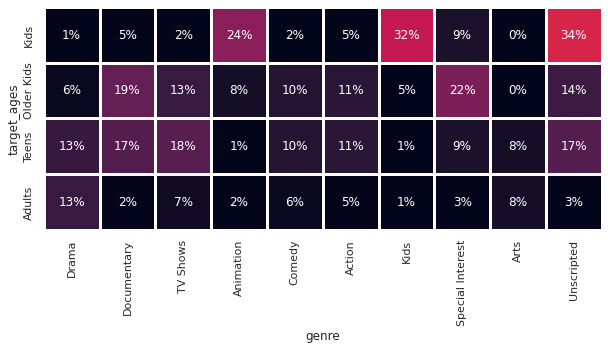

In [68]:
age_genre_heatmap(amz_tv)

# Hulu EDA

## Loading the dataset

In [69]:
hulu_basic = pd.read_csv('./hulu_titles.csv')
hulu_basic.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Ricky Velez: Here's Everything,NaN,NaN,NaN,"October 24, 2021",2021,TV-MA,NaN,"Comedy, Stand Up",​Comedian Ricky Velez bares it all with his ho...
1,s2,Movie,Silent Night,NaN,NaN,NaN,"October 23, 2021",2020,NaN,94 min,"Crime, Drama, Thriller","Mark, a low end South London hitman recently r..."
2,s3,Movie,The Marksman,NaN,NaN,NaN,"October 23, 2021",2021,PG-13,108 min,"Action, Thriller",A hardened Arizona rancher tries to protect an...
3,s4,Movie,Gaia,NaN,NaN,NaN,"October 22, 2021",2021,R,97 min,Horror,A forest ranger and two survivalists with a cu...
4,s5,Movie,Settlers,NaN,NaN,NaN,"October 22, 2021",2021,NaN,104 min,"Science Fiction, Thriller",Mankind's earliest settlers on the Martian fro...


In [70]:
# ratings 변경
add_target_ages(hulu_basic)

0           Adults
1              NaN
2            Teens
3           Adults
4              NaN
           ...    
3068    Older Kids
3069    Older Kids
3070         Teens
3071    Older Kids
3072         Teens
Name: target_ages, Length: 3073, dtype: object

In [71]:
hulu_basic.count()

show_id         3073
type            3073
title           3073
director           3
cast               0
country         1620
date_added      3045
release_year    3073
rating          2553
duration        2594
listed_in       3073
description     3069
target_ages     2553
dtype: int64

In [72]:
hulu_basic.isnull().sum()

show_id            0
type               0
title              0
director        3070
cast            3073
country         1453
date_added        28
release_year       0
rating           520
duration         479
listed_in          0
description        4
target_ages      520
dtype: int64

## Analysis based on Type

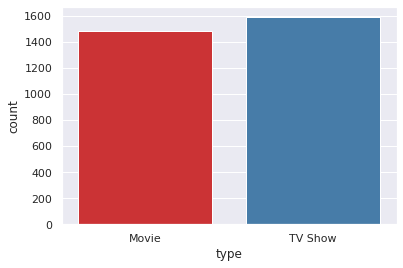

In [73]:
sns.set_style('darkgrid')
ax = sns.countplot(x="type", data=hulu_basic, palette="Set1")

In [74]:
hulu_tv = hulu_basic[hulu_basic['type']=='TV Show']

In [75]:
hulu_movie = hulu_basic[hulu_basic['type']=='Movie']

## Analysis based on Genre

### Movie

In [76]:
hulu_mg, hulu_mg_dict, hulu_mg_top10 = get_info(hulu_movie['listed_in'])

가장 많은 수의 장르:Drama
가장 적은 수의 장르: Health & Wellness


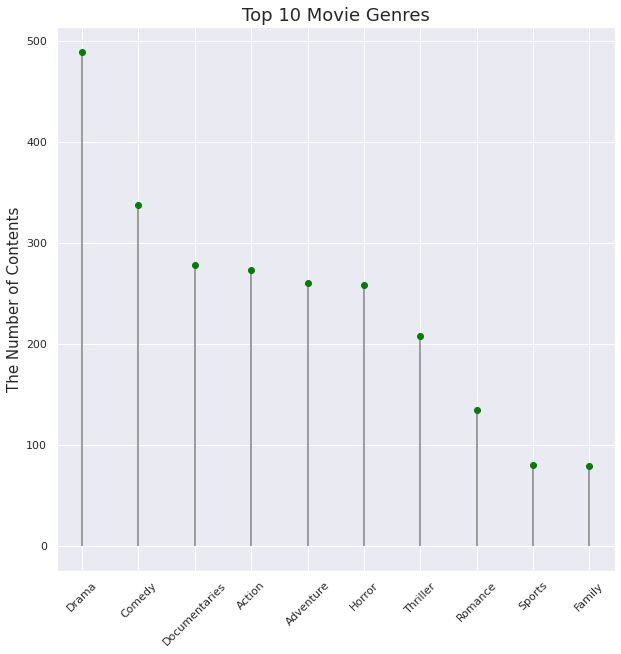

In [77]:
show_genre(hulu_mg_top10, "Top 10 Movie Genres")
print(f"가장 많은 수의 장르:{list(hulu_mg_dict.keys())[0]}\n가장 적은 수의 장르: {list(hulu_mg_dict.keys())[-1]}")

### TV Show

In [78]:
hulu_tg, hulu_tg_dict, hulu_tg_top10 = get_info(hulu_tv['listed_in'])

가장 많은 수의 장르:Drama
가장 적은 수의 장르: Arthouse


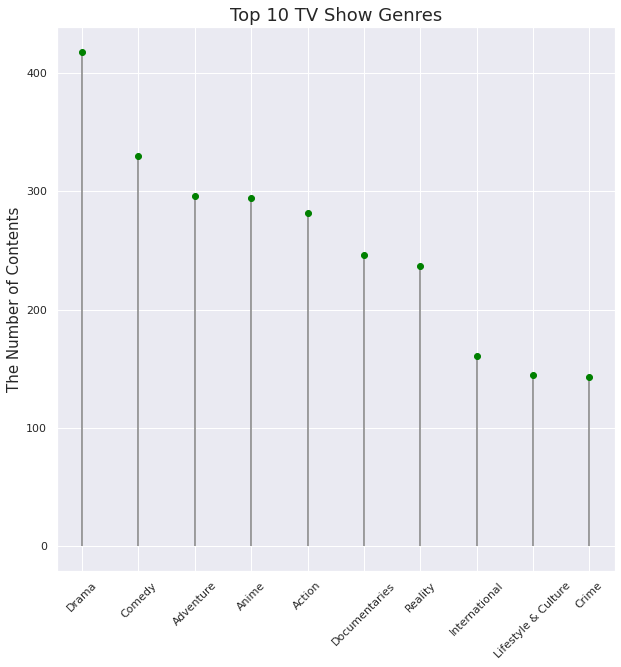

In [79]:
show_genre(hulu_tg_top10, "Top 10 TV Show Genres")
print(f"가장 많은 수의 장르:{list(hulu_tg_dict.keys())[0]}\n가장 적은 수의 장르: {list(amz_tg_dict.keys())[-1]}")

## Analysis based on Rating

### Movie

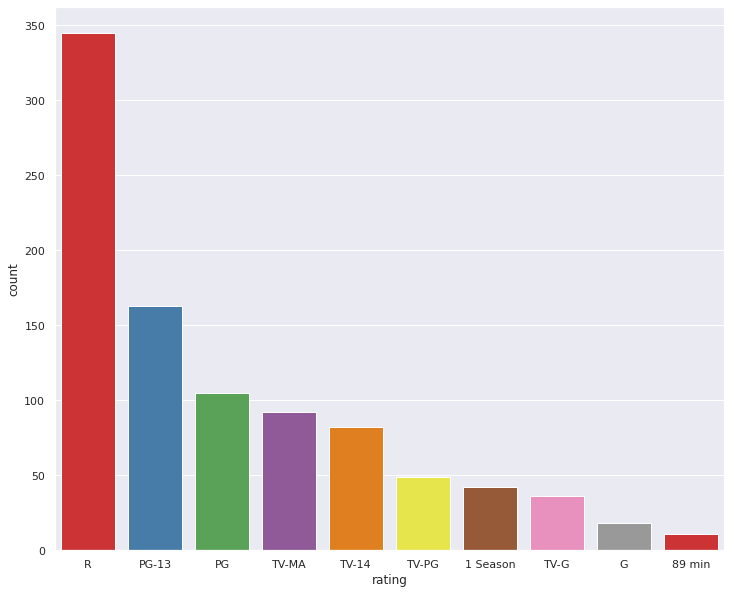

In [80]:
show_column(hulu_movie, hulu_movie['rating'], 'rating')

### TV show

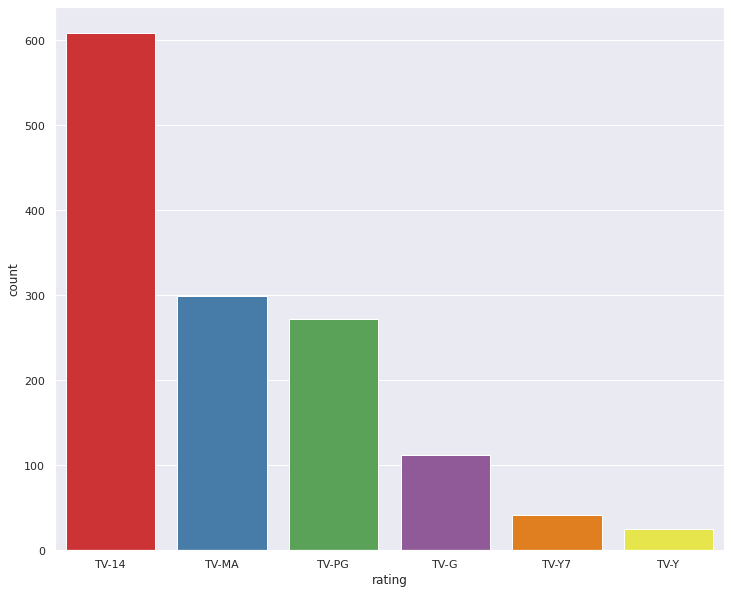

In [81]:
show_column(hulu_tv, hulu_tv['rating'], 'rating')

## Analysis based on Duration

가장 짧은 경우: 1
가장 긴 경우: 192


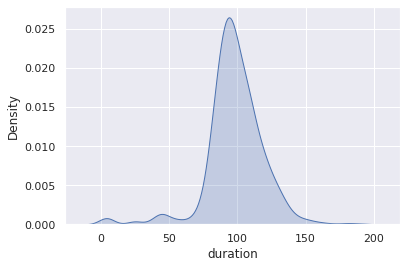

In [82]:
show_duration(hulu_movie['duration'])

가장 짧은 경우: 1
가장 긴 경우: 34


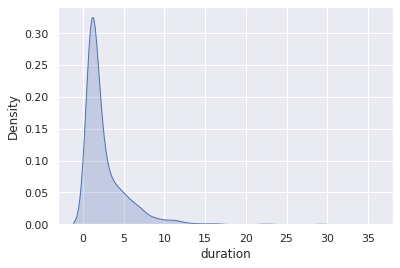

In [83]:
show_duration(hulu_tv['duration'])

## Analysis based on Year

### Movie

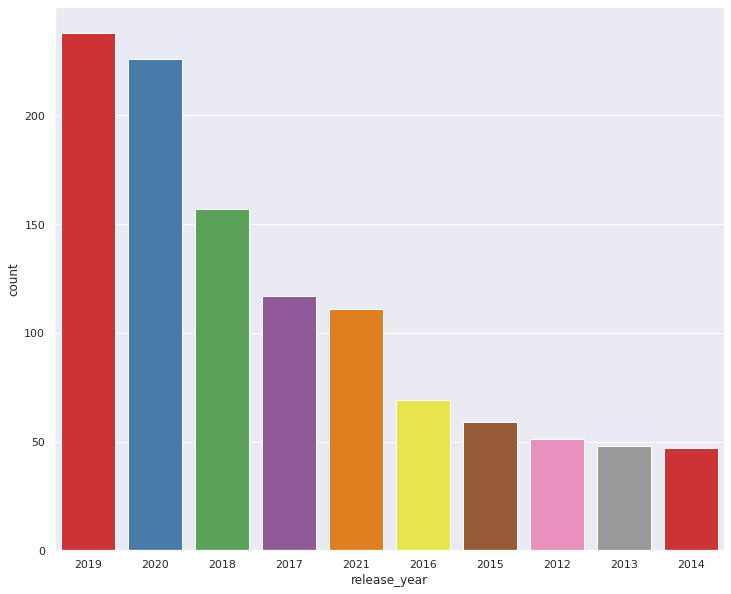

In [84]:
show_column(hulu_movie, hulu_movie['release_year'], 'release_year')

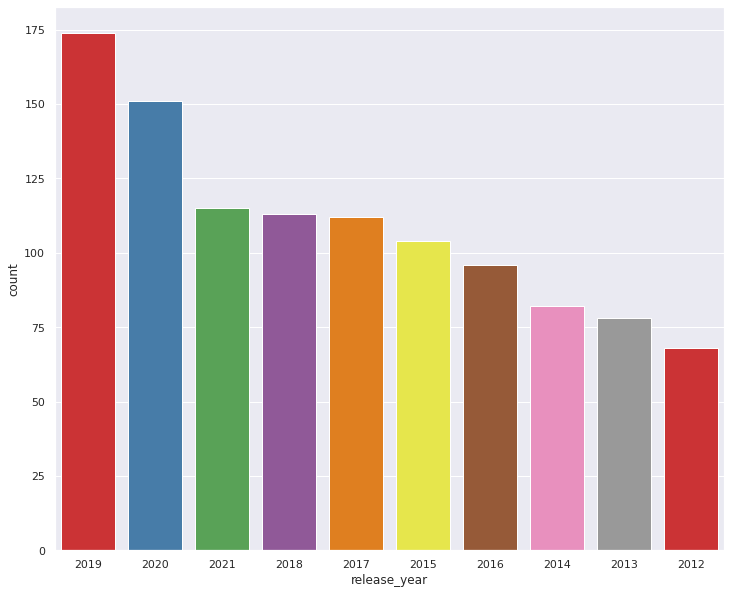

In [85]:
show_column(hulu_tv, hulu_tv['release_year'], 'release_year')

## Analysis based on Country

### Movie

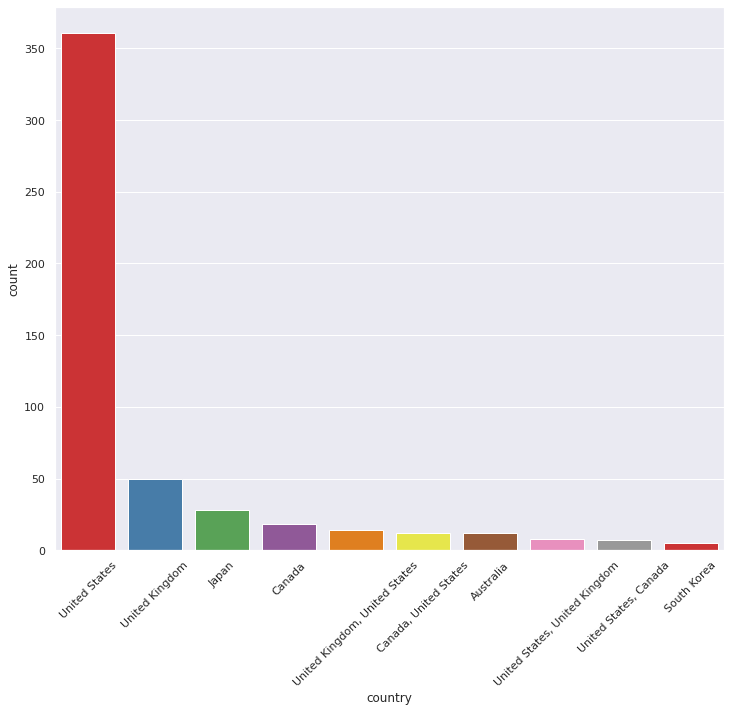

In [86]:
show_column(hulu_movie, hulu_movie['country'], 'country', 10, 45)

### TV show

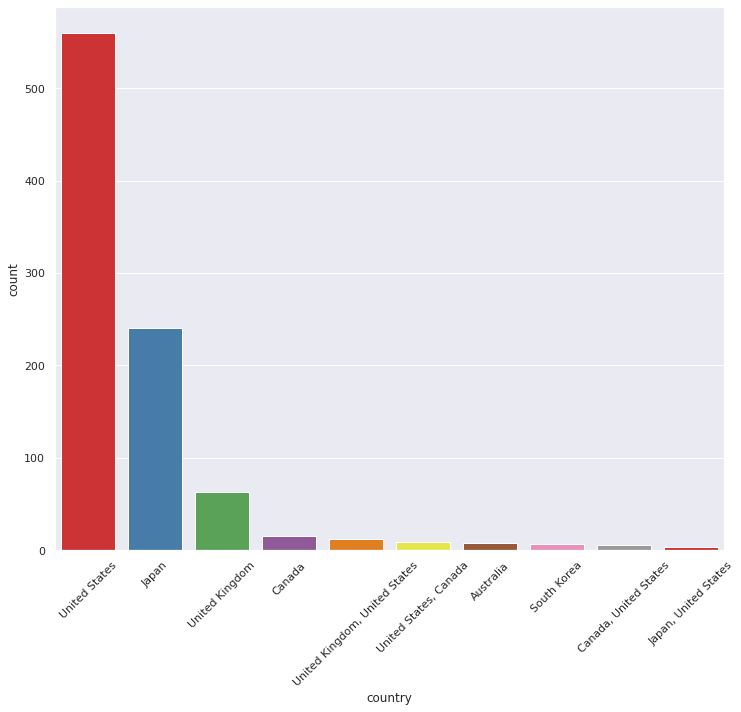

In [87]:
show_column(hulu_tv, hulu_tv['country'], 'country', 10, 45)

## Relation between Age and Genre

위에선 한 컨텐츠에 여러 장르가 쓰여있을 경우 모두 고려했지만 여기서는 가장 먼저 쓰인 장르만을 고려했다.

### Movie

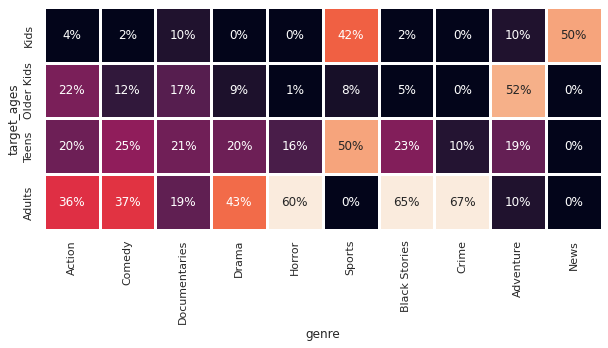

In [88]:
age_genre_heatmap(hulu_movie)

### TV Show

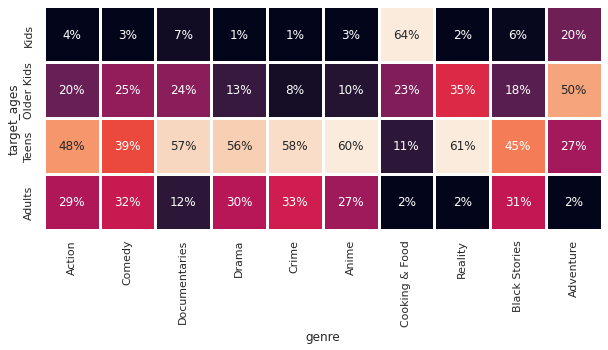

In [89]:
age_genre_heatmap(hulu_tv)

위와 같은 기본적인 EDA를 진행하고 난 뒤, 수익성 측면에서의 분석을 더 깊이 있게 하기 위해 Netflix Revenue 2020 데이터셋을 이용하기로 함. 위에서 로드한 넷플릭스 데이터셋의 released_year feature를 이용해 2018년부터 2020년 2분기까지의 각 분기에 나온 컨텐츠의 수를 합산한 뒤, 이를 각 지역 별 수익을 나타내는 데이터셋과 합친 후 합쳐진 데이터 셋의 상관관계를 분석하고자 함. 이를 통해 각 지역과 총 수익, 분기 별 공개된 컨텐츠의 수와 총 수익 사이의 상관관계를 파악할 수 있을 것.

+ 특정 컨텐츠가 추가되었을 때 총 수익이 어떻게 바뀌었는가?

## Netflix의 분기별 수익과 컨텐츠 장르 사이의 상관관계 파악하기

각 분기 별로 넷플릭스에 입성한 주된 컨텐츠가 다를 것이다. 그런 컨텐츠의 장르별 총량이 넷플릭스의 분기별 수익과 어떤 관계가 있는지 파악해보고자 한다. 기본 데이터는 분기에 관한 정보가 없으므로 released_year이라는 속성을 이용해 연도와 분기를 따로 표기해준다. 그리고 분기별 장르의 총량을 파악한 후, 해당 데이터를 수익에 관한 데이터에 추가해 수익과 장르별 총량 사이의 관계를 살펴볼 것이다.

In [90]:
# Quarter - year 형태로 바꾼 column 추가
q1 = ['January', 'February', 'March']
q2 = ['April', 'May', 'June']
q3 = ['July', 'August', 'September']
q4 = ['October', 'Novenber', 'December']

net_date_added = net_basic['date_added'].fillna('No Data')
quarter_added = []
for i in net_date_added:
    try:
        i_split = i.split(', ')
        date = []
        
        date.append(i_split[1])
        
        month = i_split[0].split(' ')[0]
        if month in q1:
            date.append('Q1')
        elif month in q2:
            date.append('Q2')
        elif month in q3:
            date.append('Q3')
        else:
            date.append('Q4')


        quarter = ' - '.join(date)

        quarter_added.append(quarter)
    except:
        quarter_added.append(i)
print(len(net_date_added))
print(quarter_added[:4])

8807
['2021 - Q3', '2021 - Q3', '2021 - Q3', '2021 - Q3']


In [91]:
net_basic['quarter_added'] = quarter_added

In [92]:
net_basic['quarter_added']

0       2021 - Q3
1       2021 - Q3
2       2021 - Q3
3       2021 - Q3
4       2021 - Q3
          ...    
8802    2019 - Q4
8803    2019 - Q3
8804    2019 - Q4
8805    2020 - Q1
8806    2019 - Q1
Name: quarter_added, Length: 8807, dtype: object

In [93]:
net_basic_reven = pd.read_csv('DataNetflixRevenue2020_V2.csv')
net_basic_reven.head()

,Area,Years,Revenue
0,United States and Canada,Q1 - 2018,1976157000
1,"Europe, Middle East and Africa",Q1 - 2018,886649000
2,Latin America,Q1 - 2018,540182000
3,Asia-Pacific,Q1 - 2018,199117000
4,United States and Canada,Q2 - 2018,2049546000


정렬을 용이하게 하기 위해 Years의 형태를 연도 - 분기 순서로 바꿔준다.

In [94]:
year_list = list(net_basic_reven['Years'])
year_list = list(map(lambda x: x.split(' - ')[1] + ' - ' + x.split(' - ')[0], year_list))

In [95]:
del net_basic_reven['Years']
net_basic_reven['Years'] = year_list
net_basic_reven.head()

,Area,Revenue,Years
0,United States and Canada,1976157000,2018 - Q1
1,"Europe, Middle East and Africa",886649000,2018 - Q1
2,Latin America,540182000,2018 - Q1
3,Asia-Pacific,199117000,2018 - Q1
4,United States and Canada,2049546000,2018 - Q2


Years를 인덱스로 하는 데이터프레임을 생성해 분기를 기준으로 지역별 총 수익을 나타낸다.

In [96]:
net_reven = net_basic_reven.pivot(index='Years', columns='Area')
net_reven.columns = net_reven.columns.droplevel(0)

In [97]:
net_reven

Area,Asia-Pacific,"Europe, Middle East and Africa",Latin America,United States and Canada
Years,,,,
2018 - Q1,199117000,886649000,540182000,1976157000
2018 - Q2,221252000,975497000,568071000,2049546000
2018 - Q3,248691000,1004749000,562307000,2094850000
2018 - Q4,276756000,1096812000,567137000,2160979000
2019 - Q1,319602000,1233379000,630472000,2256851000
2019 - Q2,349494000,1319087000,677136000,2501199000
2019 - Q3,382304000,1428040000,741434000,2621250000
2019 - Q4,418121000,1562561000,746392000,2671908000
2020 - Q1,483660000,1723474000,793453000,2702776000


지역별 수익의 총합을 나타내는 열을 추가해준다.

In [98]:
net_reven['Total'] = net_reven.sum(axis=1)
net_reven

Area,Asia-Pacific,"Europe, Middle East and Africa",Latin America,United States and Canada,Total
Years,,,,,
2018 - Q1,199117000,886649000,540182000,1976157000,3602105000
2018 - Q2,221252000,975497000,568071000,2049546000,3814366000
2018 - Q3,248691000,1004749000,562307000,2094850000,3910597000
2018 - Q4,276756000,1096812000,567137000,2160979000,4101684000
2019 - Q1,319602000,1233379000,630472000,2256851000,4440304000
2019 - Q2,349494000,1319087000,677136000,2501199000,4846916000
2019 - Q3,382304000,1428040000,741434000,2621250000,5173028000
2019 - Q4,418121000,1562561000,746392000,2671908000,5398982000
2020 - Q1,483660000,1723474000,793453000,2702776000,5703363000


분기별 올라온 컨텐츠의 총합을 구한 후, 해당 값을 net_reven 데이터프레임에 추가한다.

In [99]:
quarter_dict_all = dict(net_basic['quarter_added'].value_counts())
del quarter_dict_all['No Data']

years = [2018, 2019, 2020]
quarter_dict = {}
for i, k in quarter_dict_all.items():
    if int(i.split(' - ')[0]) in years:
        quarter_dict[i] = k

quarter_list_all = sorted(quarter_dict.items())
quarter_list = quarter_list_all[:-2] # 2020년 3분기, 4분기 제외
quarter_list

[('2018 - Q1', 379),
 ('2018 - Q2', 286),
 ('2018 - Q3', 436),
 ('2018 - Q4', 548),
 ('2019 - Q1', 467),
 ('2019 - Q2', 468),
 ('2019 - Q3', 408),
 ('2019 - Q4', 673),
 ('2020 - Q1', 455),
 ('2020 - Q2', 490)]

In [100]:
quarter_values = list(map(lambda x: x[1], quarter_list))
quarter_values

[379, 286, 436, 548, 467, 468, 408, 673, 455, 490]

In [101]:
net_reven['Number'] = quarter_values
net_reven

Area,Asia-Pacific,"Europe, Middle East and Africa",Latin America,United States and Canada,Total,Number
Years,,,,,,
2018 - Q1,199117000,886649000,540182000,1976157000,3602105000,379
2018 - Q2,221252000,975497000,568071000,2049546000,3814366000,286
2018 - Q3,248691000,1004749000,562307000,2094850000,3910597000,436
2018 - Q4,276756000,1096812000,567137000,2160979000,4101684000,548
2019 - Q1,319602000,1233379000,630472000,2256851000,4440304000,467
2019 - Q2,349494000,1319087000,677136000,2501199000,4846916000,468
2019 - Q3,382304000,1428040000,741434000,2621250000,5173028000,408
2019 - Q4,418121000,1562561000,746392000,2671908000,5398982000,673
2020 - Q1,483660000,1723474000,793453000,2702776000,5703363000,455


In [102]:
def show_plot(genre_dict, title, x_len=10, y_len=10):
    plt.figure(figsize=(x_len, y_len))
    x = list(genre_dict.keys())
    y = list(genre_dict.values())
    plt.plot(x, y, color="green")
    plt.xticks(x, rotation = 45)
    plt.ylabel("The Number of Contents", fontsize=15)
    plt.title(title, fontsize = 18)

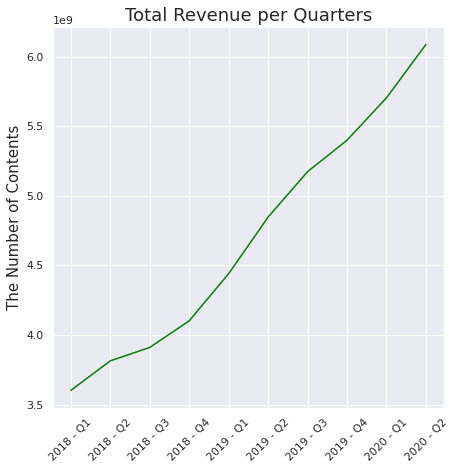

In [103]:
total_sum = dict(net_reven['Total'])
show_plot(total_sum, 'Total Revenue per Quarters', 7, 7)

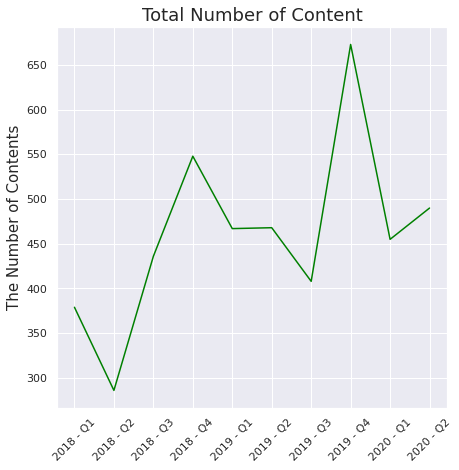

In [104]:
total_num = dict(net_reven['Number'])
show_plot(total_num, 'Total Number of Content', 7, 7)

주어진 표의 모든 열 간의 상관관계를 파악한다. 분기 별 공개된 컨텐츠의 수와 총 수익 간의 관계를 파악할 수 있다.

In [105]:
net_reven.corr(method='pearson')

Area,Asia-Pacific,"Europe, Middle East and Africa",Latin America,United States and Canada,Total,Number
Area,,,,,,
Asia-Pacific,1.000000,0.996506,0.948108,0.962122,0.987637,0.448677
"Europe, Middle East and Africa",0.996506,1.000000,0.967080,0.973463,0.994848,0.462418
Latin America,0.948108,0.967080,1.000000,0.984322,0.983077,0.402855
United States and Canada,0.962122,0.973463,0.984322,1.000000,0.991401,0.482119
Total,0.987637,0.994848,0.983077,0.991401,1.000000,0.464883
Number,0.448677,0.462418,0.402855,0.482119,0.464883,1.000000


<AxesSubplot:xlabel='Area', ylabel='Area'>

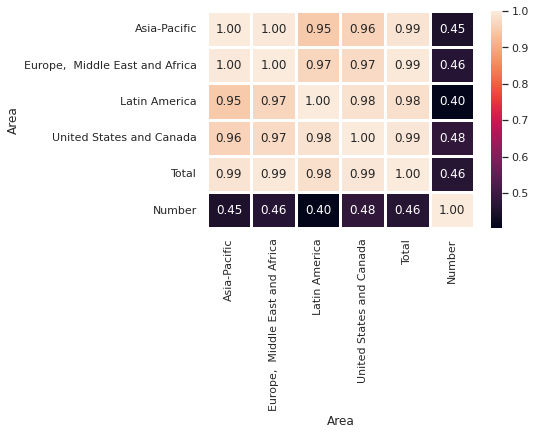

In [106]:
sns.heatmap(data=net_reven.corr(method='pearson'), annot=True, fmt='.2f', linewidths=2.5)

### 분기 별 공개된 컨텐츠 장르 분류

In [107]:
# 컨텐츠가 넷플릭스에 추가된 분기를 기준으로 정렬한다.
net_sort = net_basic.sort_values(by=['quarter_added'], ascending=[True])

In [108]:
# 정렬한 결과에서 필요한 시기의 데이터만 추출한다.
condition = net_sort['quarter_added'].isin(list(net_reven.index))
net_sort.loc[condition]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,target_ages,quarter_added
7590,s7591,Movie,No Entry,Anees Bazmee,"Anil Kapoor, Salman Khan, Fardeen Khan, Bipash...",India,"March 1, 2018",2005,TV-PG,161 min,"Comedies, International Movies","After a prank goes sideways, three buddies fin...",Older Kids,2018 - Q1
7251,s7252,Movie,LA 92,"Daniel Lindsay, T.J. Martin",NaN,United States,"March 1, 2018",2017,R,114 min,Documentaries,Previously unseen footage is shaped into a fre...,Adults,2018 - Q1
7167,s7168,Movie,Kalki,Dhilip Kumar,"Kishore Kumar G., Yasmin Ponnappa, Mithraboomi...",India,"March 1, 2018",2017,TV-14,41 min,"Dramas, Independent Movies, International Movies",A scientist trying to solve one of the univers...,Teens,2018 - Q1
7168,s7169,Movie,Kanika,NaN,"Sharad Ponkshe, Smita Shewale",India,"March 1, 2018",2017,TV-14,110 min,"Horror Movies, International Movies, Thrillers",A doctor and his colleagues who use sex-determ...,Teens,2018 - Q1
7598,s7599,Movie,Not Alone,"Kiki Goshay, Jacqueline Monetta",NaN,United States,"January 1, 2018",2017,TV-14,50 min,Documentaries,An 18-year-old struggling to understand her be...,Teens,2018 - Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,s2488,Movie,No Longer kids,Samir Al Asfory,"Said Saleh, Hassan Moustafa, Ahmed Zaki, Youne...",Egypt,"May 21, 2020",1979,TV-14,237 min,"Comedies, Dramas, International Movies",Hoping to prevent their father from skipping t...,Teens,2020 - Q2
6090,s6091,Movie,Addicted to Life,Thierry Donard,"Antoine Bizet, Jesse Richman, Karsten Gefle, W...",France,"June 12, 2020",2014,TV-14,91 min,"Action & Adventure, Documentaries, Internation...","Chasing extreme challenges, athletic daredevil...",Teens,2020 - Q2
6086,s6087,Movie,Act of Valor,"Mike McCoy, Scott Waugh","Keo Woolford, Drea Castro, Emilio Rivera, Rork...",United States,"June 1, 2020",2012,R,110 min,Action & Adventure,An elite squad of Navy SEALs is tasked with re...,Adults,2020 - Q2
2443,s2444,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",Adults,2020 - Q2


In [109]:
# 분기별로 생성된 컨텐츠의 제목을 저장
quarter_title = {}
for i in list(net_reven.index):
    quarter_title[i] = list(net_sort[net_sort['quarter_added']==i]['title'])

## Correlation between Genre and Revenue

분기별로 공개된 컨텐츠를 장르별로 구분하고, 총합을 구해 수익과의 관계성을 살펴볼 것이다.

In [110]:
net_quarter = net_basic[net_basic['quarter_added'].isin(list(net_reven.index))]
net_quarter_sort = net_quarter.sort_values(by='quarter_added')
net_quarter_sort

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,target_ages,quarter_added
6057,s6058,Movie,A Serious Man,"Ethan Coen, Joel Coen","Michael Stuhlbarg, Richard Kind, Fred Melamed,...","United States, United Kingdom, France","January 16, 2018",2009,R,106 min,"Comedies, Independent Movies","With every aspect of his life unraveling, a Je...",Adults,2018 - Q1
4995,s4996,Movie,Ladies First,Uraaz Bahl,NaN,India,"March 8, 2018",2018,TV-G,40 min,"Documentaries, International Movies, Sports Mo...",Born amid poverty and limited women's rights i...,Kids,2018 - Q1
6966,s6967,Movie,Hide & Seek,Shawn Arranha,"Purab Kohli, Arjan Bajwa, Mrinalini Sharma, Sa...",India,"March 1, 2018",2010,TV-14,96 min,"Horror Movies, International Movies, Thrillers",Years after an accident at a wild Christmas pa...,Teens,2018 - Q1
4996,s4997,Movie,Bullet Head,"Paul Solet, Rick Benattar","Adrien Brody, John Malkovich, Rory Culkin, Ant...","Bulgaria, United States","March 7, 2018",2017,R,94 min,"International Movies, Thrillers","After a daring heist, three fugitives lock the...",Adults,2018 - Q1
4997,s4998,TV Show,Borderliner,NaN,"Tobias Santelmann, Ellen Dorrit Petersen, Benj...","Norway, Germany, Sweden","March 6, 2018",2017,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas","To protect his family, a police detective cove...",Adults,2018 - Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,s2583,Movie,Madagascar: Escape 2 Africa,"Eric Darnell, Tom McGrath","Ben Stiller, Chris Rock, David Schwimmer, Jada...",United States,"May 1, 2020",2008,PG,91 min,"Children & Family Movies, Comedies",A botched rescue strands Alex the lion and his...,Older Kids,2020 - Q2
2581,s2582,Movie,I Am Divine,Jeffrey Schwarz,NaN,United States,"May 1, 2020",2013,TV-MA,90 min,"Documentaries, LGBTQ Movies",This captivating documentary explores the life...,Adults,2020 - Q2
2580,s2581,TV Show,Hollywood,NaN,"David Corenswet, Darren Criss, Patti LuPone, J...",United States,"May 1, 2020",2020,TV-MA,1 Season,TV Dramas,"In post-World War II Hollywood, an ambitious g...",Adults,2020 - Q2
2587,s2588,Movie,Mrs. Serial Killer,Shirish Kunder,"Jacqueline Fernandez, Manoj Bajpayee, Mohit Ra...",India,"May 1, 2020",2020,TV-MA,107 min,"International Movies, Thrillers",When a doctor gets jailed for a string of shoc...,Adults,2020 - Q2


시청 연령과 장르 사이의 관계를 파악할 땐 제일 앞에 쓰인 장르만 이용했지만 그렇게 하면 누락된 장르가 생긴다. 따라서 모든 장르를 추가하기 위해 다음과 같은 처리를 해준다. 데이터 상에 나와있는 장르를 모두 열로 추가한 뒤 우선 모든 값을 0으로 만든다. listed_in 특성에서 해당사항이 있을 경우 열의 값을 1로 바꾼다.

In [111]:
genre = list(set(net_mg + net_tg))

In [112]:
for i in genre:
    net_quarter_sort[i] = 0
net_quarter_sort = net_quarter_sort.fillna(0)
net_quarter_sort

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Thrillers,Dramas,Independent Movies,Romantic Movies,Comedies,TV Comedies,Sci-Fi & Fantasy,International TV Shows,Romantic TV Shows,Music & Musicals
6057,s6058,Movie,A Serious Man,"Ethan Coen, Joel Coen","Michael Stuhlbarg, Richard Kind, Fred Melamed,...","United States, United Kingdom, France","January 16, 2018",2009,R,106 min,...,0,0,0,0,0,0,0,0,0,0
4995,s4996,Movie,Ladies First,Uraaz Bahl,0,India,"March 8, 2018",2018,TV-G,40 min,...,0,0,0,0,0,0,0,0,0,0
6966,s6967,Movie,Hide & Seek,Shawn Arranha,"Purab Kohli, Arjan Bajwa, Mrinalini Sharma, Sa...",India,"March 1, 2018",2010,TV-14,96 min,...,0,0,0,0,0,0,0,0,0,0
4996,s4997,Movie,Bullet Head,"Paul Solet, Rick Benattar","Adrien Brody, John Malkovich, Rory Culkin, Ant...","Bulgaria, United States","March 7, 2018",2017,R,94 min,...,0,0,0,0,0,0,0,0,0,0
4997,s4998,TV Show,Borderliner,0,"Tobias Santelmann, Ellen Dorrit Petersen, Benj...","Norway, Germany, Sweden","March 6, 2018",2017,TV-MA,1 Season,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,s2583,Movie,Madagascar: Escape 2 Africa,"Eric Darnell, Tom McGrath","Ben Stiller, Chris Rock, David Schwimmer, Jada...",United States,"May 1, 2020",2008,PG,91 min,...,0,0,0,0,0,0,0,0,0,0
2581,s2582,Movie,I Am Divine,Jeffrey Schwarz,0,United States,"May 1, 2020",2013,TV-MA,90 min,...,0,0,0,0,0,0,0,0,0,0
2580,s2581,TV Show,Hollywood,0,"David Corenswet, Darren Criss, Patti LuPone, J...",United States,"May 1, 2020",2020,TV-MA,1 Season,...,0,0,0,0,0,0,0,0,0,0
2587,s2588,Movie,Mrs. Serial Killer,Shirish Kunder,"Jacqueline Fernandez, Manoj Bajpayee, Mohit Ra...",India,"May 1, 2020",2020,TV-MA,107 min,...,0,0,0,0,0,0,0,0,0,0


In [113]:
# 각 컨텐츠의 장르
net_genre = list(map(lambda x: x.split(', '), list(net_quarter_sort['listed_in'])))
net_genre_dict = {}

for i, k in zip(list(net_quarter_sort.index), net_genre):
    net_genre_dict[i] = k

In [114]:
for i, k in net_genre_dict.items():
    for j in k:
        net_quarter_sort.loc[i, j] = 1
        
net_quarter_sort = net_quarter_sort.fillna(0)

In [115]:
quarter_genre = net_quarter_sort.groupby('quarter_added')[genre].sum()
quarter_genre

,Children & Family Movies,TV Horror,Reality TV,Crime TV Shows,Action & Adventure,Cult Movies,Docuseries,Korean TV Shows,Kids' TV,Stand-Up Comedy,...,TV Thrillers,Dramas,Independent Movies,Romantic Movies,Comedies,TV Comedies,Sci-Fi & Fantasy,International TV Shows,Romantic TV Shows,Music & Musicals
quarter_added,,,,,,,,,,,,,,,,,,,,,
2018 - Q1,22,3,2,21,37,3,13,5,9,23,...,2,128,40,22,56,13,15,46,8,29
2018 - Q2,18,2,3,13,25,1,6,2,15,22,...,0,82,32,21,44,24,11,47,11,6
2018 - Q3,16,2,11,21,56,5,21,2,15,15,...,0,154,54,32,101,22,12,54,9,21
2018 - Q4,29,3,25,30,55,3,24,5,26,29,...,3,167,37,33,96,41,18,67,16,40
2019 - Q1,36,6,8,25,48,3,27,6,14,17,...,3,161,65,32,89,23,17,75,23,17
2019 - Q2,29,3,11,30,39,1,14,5,16,13,...,2,119,50,37,100,38,17,81,20,23
2019 - Q3,25,6,18,26,32,4,25,17,22,17,...,4,83,33,21,69,14,16,72,18,13
2019 - Q4,57,3,23,29,83,14,23,24,31,19,...,4,201,53,60,162,42,20,107,35,24
2020 - Q1,45,5,15,31,46,6,19,12,27,15,...,2,122,43,37,98,25,25,71,17,17


수익과의 관계성을 보기 위해 수익을 추가해준다.

In [116]:
quarter_genre['Total revenue'] = list(net_reven['Total'])
quarter_genre

,Children & Family Movies,TV Horror,Reality TV,Crime TV Shows,Action & Adventure,Cult Movies,Docuseries,Korean TV Shows,Kids' TV,Stand-Up Comedy,...,Dramas,Independent Movies,Romantic Movies,Comedies,TV Comedies,Sci-Fi & Fantasy,International TV Shows,Romantic TV Shows,Music & Musicals,Total revenue
quarter_added,,,,,,,,,,,,,,,,,,,,,
2018 - Q1,22,3,2,21,37,3,13,5,9,23,...,128,40,22,56,13,15,46,8,29,3602105000
2018 - Q2,18,2,3,13,25,1,6,2,15,22,...,82,32,21,44,24,11,47,11,6,3814366000
2018 - Q3,16,2,11,21,56,5,21,2,15,15,...,154,54,32,101,22,12,54,9,21,3910597000
2018 - Q4,29,3,25,30,55,3,24,5,26,29,...,167,37,33,96,41,18,67,16,40,4101684000
2019 - Q1,36,6,8,25,48,3,27,6,14,17,...,161,65,32,89,23,17,75,23,17,4440304000
2019 - Q2,29,3,11,30,39,1,14,5,16,13,...,119,50,37,100,38,17,81,20,23,4846916000
2019 - Q3,25,6,18,26,32,4,25,17,22,17,...,83,33,21,69,14,16,72,18,13,5173028000
2019 - Q4,57,3,23,29,83,14,23,24,31,19,...,201,53,60,162,42,20,107,35,24,5398982000
2020 - Q1,45,5,15,31,46,6,19,12,27,15,...,122,43,37,98,25,25,71,17,17,5703363000


In [117]:
quarter_genre.corrwith(quarter_genre['Total revenue'])

Children & Family Movies        0.726174
TV Horror                       0.710295
Reality TV                      0.551195
Crime TV Shows                  0.669671
Action & Adventure              0.241114
Cult Movies                     0.427667
Docuseries                      0.211792
Korean TV Shows                 0.740684
Kids' TV                        0.544032
Stand-Up Comedy                -0.614803
Anime Features                  0.710781
Faith & Spirituality           -0.277613
Classic Movies                  0.564767
Teen TV Shows                   0.491661
Stand-Up Comedy & Talk Shows   -0.413263
Documentaries                  -0.371438
International Movies           -0.039805
Sports Movies                   0.514895
Spanish-Language TV Shows       0.431542
TV Dramas                       0.634145
LGBTQ Movies                   -0.185141
Anime Series                    0.755089
Classic & Cult TV               0.050538
Horror Movies                   0.187276
TV Mysteries    

In [118]:
genre_cor_dict = dict(quarter_genre.corrwith(quarter_genre['Total revenue']))

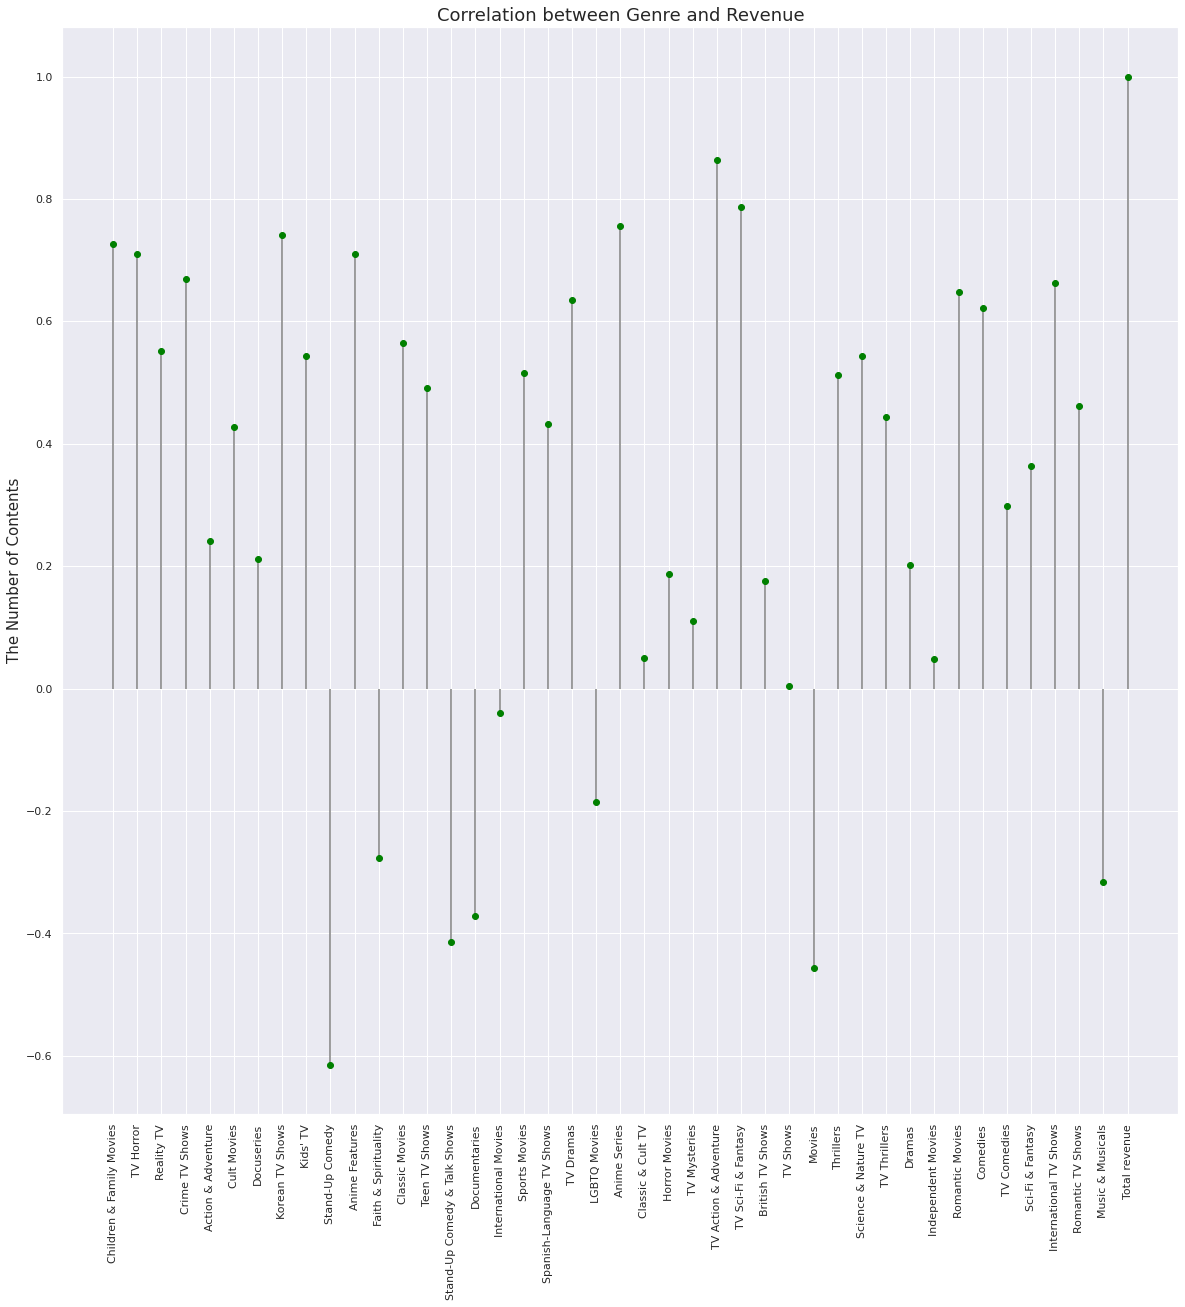

In [119]:
show_genre(genre_cor_dict, 'Correlation between Genre and Revenue', 20, 20, 90)

In [120]:
over_4 = list(dict(filter(lambda x: x[1] > 0.4 and x[1] < 0.6, genre_cor_dict.items())).keys())
over_6 = list(dict(filter(lambda x: x[1] > 0.6 and x[1] < 0.8, genre_cor_dict.items())).keys())
over_8 = list(dict(filter(lambda x: x[1] > 0.8, genre_cor_dict.items())).keys())
over_8.remove('Total revenue')
print(f"약한 상관성: \n{over_4}\n\n\n상관성: \n{over_6}\n\n\n강한 상관성: \n{over_8}")

약한 상관성: 
['Reality TV', 'Cult Movies', "Kids' TV", 'Classic Movies', 'Teen TV Shows', 'Sports Movies', 'Spanish-Language TV Shows', 'Thrillers', 'Science & Nature TV', 'TV Thrillers', 'Romantic TV Shows']


상관성: 
['Children & Family Movies', 'TV Horror', 'Crime TV Shows', 'Korean TV Shows', 'Anime Features', 'TV Dramas', 'Anime Series', 'TV Sci-Fi & Fantasy', 'Romantic Movies', 'Comedies', 'International TV Shows']


강한 상관성: 
['TV Action & Adventure']


위와 같이 상관성의 수치에 따라 장르를 분류해볼 수 있었다. 하지만 위의 결과는 어디까지나 어떤 장르가 업로드된 수와 수익성 간의 상관관계이다. 따라서 특정 장르의 업로드 수와 시청자 수, 구독자의 증가 등 실질적으로 수익과 관련성 있는 요소의 관련성을 주장을 하기 위해선 좀 더 근거가 필요할 것이다.

## Correlation between Ages and Revenue

장르와 수익 사이 관계를 파악한 것과 유사한 방식으로 진행한다.

In [121]:
# 연령 원-핫 인코딩
ages = pd.get_dummies(net_quarter_sort['target_ages'])
ages.iloc[:, 1:]

,Adults,Kids,Older Kids,Teens
6057,1,0,0,0
4995,0,1,0,0
6966,0,0,0,1
4996,1,0,0,0
4997,1,0,0,0
...,...,...,...,...
2582,0,0,1,0
2581,1,0,0,0
2580,1,0,0,0
2587,1,0,0,0


In [122]:
net_add_ages = pd.concat([net_quarter_sort, ages.iloc[:, 1:]], axis=1)

In [123]:
net_add_ages

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,Comedies,TV Comedies,Sci-Fi & Fantasy,International TV Shows,Romantic TV Shows,Music & Musicals,Adults,Kids,Older Kids,Teens
6057,s6058,Movie,A Serious Man,"Ethan Coen, Joel Coen","Michael Stuhlbarg, Richard Kind, Fred Melamed,...","United States, United Kingdom, France","January 16, 2018",2009,R,106 min,...,1,0,0,0,0,0,1,0,0,0
4995,s4996,Movie,Ladies First,Uraaz Bahl,0,India,"March 8, 2018",2018,TV-G,40 min,...,0,0,0,0,0,0,0,1,0,0
6966,s6967,Movie,Hide & Seek,Shawn Arranha,"Purab Kohli, Arjan Bajwa, Mrinalini Sharma, Sa...",India,"March 1, 2018",2010,TV-14,96 min,...,0,0,0,0,0,0,0,0,0,1
4996,s4997,Movie,Bullet Head,"Paul Solet, Rick Benattar","Adrien Brody, John Malkovich, Rory Culkin, Ant...","Bulgaria, United States","March 7, 2018",2017,R,94 min,...,0,0,0,0,0,0,1,0,0,0
4997,s4998,TV Show,Borderliner,0,"Tobias Santelmann, Ellen Dorrit Petersen, Benj...","Norway, Germany, Sweden","March 6, 2018",2017,TV-MA,1 Season,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,s2583,Movie,Madagascar: Escape 2 Africa,"Eric Darnell, Tom McGrath","Ben Stiller, Chris Rock, David Schwimmer, Jada...",United States,"May 1, 2020",2008,PG,91 min,...,1,0,0,0,0,0,0,0,1,0
2581,s2582,Movie,I Am Divine,Jeffrey Schwarz,0,United States,"May 1, 2020",2013,TV-MA,90 min,...,0,0,0,0,0,0,1,0,0,0
2580,s2581,TV Show,Hollywood,0,"David Corenswet, Darren Criss, Patti LuPone, J...",United States,"May 1, 2020",2020,TV-MA,1 Season,...,0,0,0,0,0,0,1,0,0,0
2587,s2588,Movie,Mrs. Serial Killer,Shirish Kunder,"Jacqueline Fernandez, Manoj Bajpayee, Mohit Ra...",India,"May 1, 2020",2020,TV-MA,107 min,...,0,0,0,0,0,0,1,0,0,0


In [124]:
net_ages = net_add_ages[['quarter_added', 'Adults', 'Kids', 'Older Kids', 'Teens']]
net_ages

,quarter_added,Adults,Kids,Older Kids,Teens
6057,2018 - Q1,1,0,0,0
4995,2018 - Q1,0,1,0,0
6966,2018 - Q1,0,0,0,1
4996,2018 - Q1,1,0,0,0
4997,2018 - Q1,1,0,0,0
...,...,...,...,...,...
2582,2020 - Q2,0,0,1,0
2581,2020 - Q2,1,0,0,0
2580,2020 - Q2,1,0,0,0
2587,2020 - Q2,1,0,0,0


In [125]:
quarter_ages = net_ages.groupby('quarter_added')[['Adults', 'Kids', 'Older Kids', 'Teens']].sum()
quarter_ages

,Adults,Kids,Older Kids,Teens
quarter_added,,,,
2018 - Q1,189.0,12.0,67.0,110.0
2018 - Q2,148.0,29.0,36.0,73.0
2018 - Q3,213.0,10.0,69.0,144.0
2018 - Q4,243.0,37.0,91.0,177.0
2019 - Q1,233.0,15.0,74.0,145.0
2019 - Q2,247.0,14.0,68.0,139.0
2019 - Q3,183.0,31.0,74.0,120.0
2019 - Q4,288.0,42.0,118.0,225.0
2020 - Q1,233.0,36.0,66.0,120.0


In [126]:
quarter_ages['Total revenue'] = list(net_reven['Total'])

In [127]:
ages_cor_dict = dict(quarter_ages.corrwith(quarter_ages['Total revenue']))

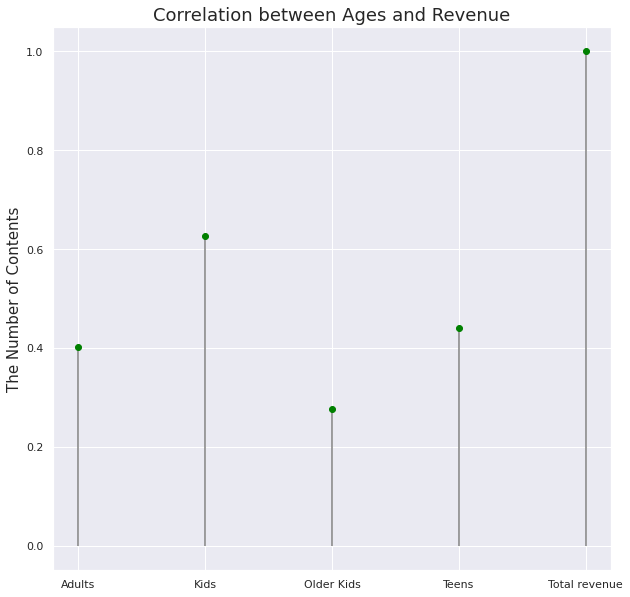

In [128]:
show_genre(ages_cor_dict, 'Correlation between Ages and Revenue', 10, 10, 0)

시청 연령을 기준으로 했을 때 가장 상관관계가 높게 나타난 것은 Kids였다. 앞서 분석한 장르에서도 Kid's TV는 약한 상관성을 띄는 것으로 결과가 나왔다. 장르와 수익만을 봤을 땐 큰 상관성이 없다고 볼 수 있지만, 연령을 중심으로 봤을 때도 Kids가 영향을 끼치는 것으로 나온 것을 보면 아동 시장 또한 넷플릭스가 투자해볼 수 있는 시장이 될 것이다.

## 상관성이 비교적 높은 장르
위에서 상관관계를 분석했을 때 값이 0.5를 넘는 장르를 모아보았다.

In [129]:
n_genre_dict = dict(filter(lambda x: x[1] > 0.5, genre_cor_dict.items()))
del n_genre_dict['Total revenue']

n_genre_list = sorted(n_genre_dict.items(), key=lambda x: x[1], reverse=True)

In [130]:
cor_genre_list = [i for i, k in n_genre_list]
cor_genre_list

['TV Action & Adventure',
 'TV Sci-Fi & Fantasy',
 'Anime Series',
 'Korean TV Shows',
 'Children & Family Movies',
 'Anime Features',
 'TV Horror',
 'Crime TV Shows',
 'International TV Shows',
 'Romantic Movies',
 'TV Dramas',
 'Comedies',
 'Classic Movies',
 'Reality TV',
 "Kids' TV",
 'Science & Nature TV',
 'Sports Movies',
 'Thrillers']

In [131]:
# 장르에 해당되는 컨텐츠만 모은 데이터프레임을 사전에 저장
genre_dicts = {}
for genre in cor_genre_list:
    genre_dicts[genre] = net_quarter_sort[net_quarter_sort['listed_in'].str.contains(genre)]

# 첫 번째 장르에 해당하는 컨텐츠의 제목
list(genre_dicts[cor_genre_list[0]]['title'])[:5]

['Dragons: Race to the Edge',
 'Valor',
 'The Shannara Chronicles',
 'Star Trek: The Next Generation',
 "Marvel's Luke Cage"]

수익과 상관성이 높았던 장르에 해당하는 컨텐츠의 경우, 평점 또한 높을 것이라고 생각했다. 그럴 경우 수익성과의 상관관계에 있어서 평점이 높은 장르를 집중적으로 업로드 하는 등의 방식을 생각해볼 수 있을 것이다. 이러한 가설을 증명하기 위해 다음과 같은 과정을 거쳤다.

In [132]:
# 컨텐츠 평가 결과 로드
rating_basic = pd.read_csv('netflix-rotten-tomatoes-metacritic-imdb.csv')
rating = rating_basic[['Title', 'Hidden Gem Score']]
rating.columns = ['title', 'score']
rating.head()

,title,score
0,Lets Fight Ghost,4.3
1,HOW TO BUILD A GIRL,7.0
2,Centigrade,6.4
3,ANNE+,7.7
4,Moxie,8.1


In [133]:
rating_dict = {}
for i in cor_genre_list:
    for j in list(genre_dicts[i]['title']):
        if j in list(rating['title']):
            rating_dict[j] = list(rating[rating['title']==j].score)[0]
rating_dict['Valor']

9.1

In [134]:
net_genre_df = net_quarter_sort[cor_genre_list]
net_genre_df.insert(0, 'title', list(net_quarter_sort['title']))
net_genre_df.insert(1, 'quarter_added', list(net_quarter_sort['quarter_added']))
net_genre_df

,title,quarter_added,TV Action & Adventure,TV Sci-Fi & Fantasy,Anime Series,Korean TV Shows,Children & Family Movies,Anime Features,TV Horror,Crime TV Shows,International TV Shows,Romantic Movies,TV Dramas,Comedies,Classic Movies,Reality TV,Kids' TV,Science & Nature TV,Sports Movies,Thrillers
6057,A Serious Man,2018 - Q1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4995,Ladies First,2018 - Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6966,Hide & Seek,2018 - Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4996,Bullet Head,2018 - Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4997,Borderliner,2018 - Q1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,Madagascar: Escape 2 Africa,2020 - Q2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2581,I Am Divine,2020 - Q2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2580,Hollywood,2020 - Q2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2587,Mrs. Serial Killer,2020 - Q2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [135]:
net_genre_df['score'] = 0
for i, k in rating_dict.items():
    for v, j in zip(list(net_genre_df.index), list(net_genre_df['title'])):
        if i == j:
            net_genre_df.loc[v, 'score'] = k
net_genre_df

,title,quarter_added,TV Action & Adventure,TV Sci-Fi & Fantasy,Anime Series,Korean TV Shows,Children & Family Movies,Anime Features,TV Horror,Crime TV Shows,...,Romantic Movies,TV Dramas,Comedies,Classic Movies,Reality TV,Kids' TV,Science & Nature TV,Sports Movies,Thrillers,score
6057,A Serious Man,2018 - Q1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.0
4995,Ladies First,2018 - Q1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8.4
6966,Hide & Seek,2018 - Q1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
4996,Bullet Head,2018 - Q1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.4
4997,Borderliner,2018 - Q1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,Madagascar: Escape 2 Africa,2020 - Q2,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,3.2
2581,I Am Divine,2020 - Q2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2580,Hollywood,2020 - Q2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3.8
2587,Mrs. Serial Killer,2020 - Q2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.2


평점이 없는 자료는 제거한다

In [136]:
idx = net_genre_df[net_genre_df['score']==0].index

In [137]:
genre_df = net_genre_df.drop(idx)
genre_df

,title,quarter_added,TV Action & Adventure,TV Sci-Fi & Fantasy,Anime Series,Korean TV Shows,Children & Family Movies,Anime Features,TV Horror,Crime TV Shows,...,Romantic Movies,TV Dramas,Comedies,Classic Movies,Reality TV,Kids' TV,Science & Nature TV,Sports Movies,Thrillers,score
4995,Ladies First,2018 - Q1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8.4
4996,Bullet Head,2018 - Q1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.4
4997,Borderliner,2018 - Q1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,6.8
4999,Expedition China,2018 - Q1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,8.1
5000,Flint Town,2018 - Q1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,Medici: Masters of Florence,2020 - Q2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4.0
2584,Material,2020 - Q2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,7.6
2582,Madagascar: Escape 2 Africa,2020 - Q2,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,3.2
2580,Hollywood,2020 - Q2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3.8


In [138]:
genre = list(genre_df.columns[2:])
quarter = list(net_reven.index)
quarter.sort()
genre[:5]

['TV Action & Adventure',
 'TV Sci-Fi & Fantasy',
 'Anime Series',
 'Korean TV Shows',
 'Children & Family Movies']

In [139]:
quarter_genre

,Children & Family Movies,TV Horror,Reality TV,Crime TV Shows,Action & Adventure,Cult Movies,Docuseries,Korean TV Shows,Kids' TV,Stand-Up Comedy,...,Dramas,Independent Movies,Romantic Movies,Comedies,TV Comedies,Sci-Fi & Fantasy,International TV Shows,Romantic TV Shows,Music & Musicals,Total revenue
quarter_added,,,,,,,,,,,,,,,,,,,,,
2018 - Q1,22,3,2,21,37,3,13,5,9,23,...,128,40,22,56,13,15,46,8,29,3602105000
2018 - Q2,18,2,3,13,25,1,6,2,15,22,...,82,32,21,44,24,11,47,11,6,3814366000
2018 - Q3,16,2,11,21,56,5,21,2,15,15,...,154,54,32,101,22,12,54,9,21,3910597000
2018 - Q4,29,3,25,30,55,3,24,5,26,29,...,167,37,33,96,41,18,67,16,40,4101684000
2019 - Q1,36,6,8,25,48,3,27,6,14,17,...,161,65,32,89,23,17,75,23,17,4440304000
2019 - Q2,29,3,11,30,39,1,14,5,16,13,...,119,50,37,100,38,17,81,20,23,4846916000
2019 - Q3,25,6,18,26,32,4,25,17,22,17,...,83,33,21,69,14,16,72,18,13,5173028000
2019 - Q4,57,3,23,29,83,14,23,24,31,19,...,201,53,60,162,42,20,107,35,24,5398982000
2020 - Q1,45,5,15,31,46,6,19,12,27,15,...,122,43,37,98,25,25,71,17,17,5703363000


In [140]:
ratings_of_genre = []
quarter_genre_df = quarter_genre[list(genre_df.columns[2:-1])]
quarter_genre_df['Total revenue'] = list(quarter_genre['Total revenue'])
quarter_genre_df['score'] = 0

for i in quarter:
    for j in genre:
        # 특정 장르에 해당하는 영화를 분기와 상관없이 모두 추출
        specific = genre_df[genre_df[j]==1]
        # 분기 별로 장르의 평균 구함
        specific = specific[genre_df['quarter_added']==i]
        mean_score = specific['score'].mean()
        quarter_genre_df.loc[i, j] = mean_score
        # 장르별로 영화를 구분해 저장
        specific_df = pd.DataFrame(np.array(specific['score']), index=[[j]*len(specific),specific['title']], columns=['score'])
        ratings_of_genre.append(specific_df)

In [141]:
quarter_genre_df.dropna(axis=1)

,TV Action & Adventure,Anime Series,Korean TV Shows,Children & Family Movies,Crime TV Shows,International TV Shows,Romantic Movies,TV Dramas,Comedies,Reality TV,Kids' TV,Sports Movies,Thrillers,Total revenue
quarter_added,,,,,,,,,,,,,,
2018 - Q1,5.666667,5.620000,8.700000,6.455556,5.993333,6.538710,5.463636,6.476471,5.709524,8.100000,6.960000,7.120000,4.966667,3602105000
2018 - Q2,4.233333,7.866667,7.200000,5.366667,6.930000,7.371429,5.584615,6.940000,5.754054,8.066667,7.290909,6.140000,4.755556,3814366000
2018 - Q3,7.520000,8.000000,5.200000,5.533333,7.025000,7.770270,5.282609,6.778947,6.029851,7.862500,7.512500,8.260000,4.368421,3910597000
2018 - Q4,5.333333,7.228571,7.925000,5.923529,6.647619,7.383333,5.678261,6.745833,6.530380,7.428571,8.118750,6.566667,5.628000,4101684000
2019 - Q1,4.675000,6.400000,8.083333,4.476190,7.166667,7.441818,7.650000,6.928571,6.166071,7.825000,7.491667,5.800000,4.986667,4440304000
2019 - Q2,6.800000,6.500000,8.020000,5.946667,6.876923,6.981818,5.200000,6.004000,5.480282,7.850000,8.140000,6.300000,4.722222,4846916000
2019 - Q3,5.100000,6.900000,8.046667,5.150000,6.876190,7.301818,3.692857,6.264286,5.676471,7.390909,8.166667,5.142857,4.807143,5173028000
2019 - Q4,5.475000,7.488889,7.678947,5.922222,6.891667,7.588889,5.480556,6.808333,5.053535,7.910000,7.210000,6.221429,4.763636,5398982000
2020 - Q1,5.475000,6.430000,7.627273,5.562069,5.839286,6.615873,5.617857,5.729268,5.170588,7.411111,8.010526,6.690000,4.726667,5703363000


In [142]:
genre_cor_dict = dict(quarter_genre_df.corrwith(quarter_genre_df['Total revenue']))

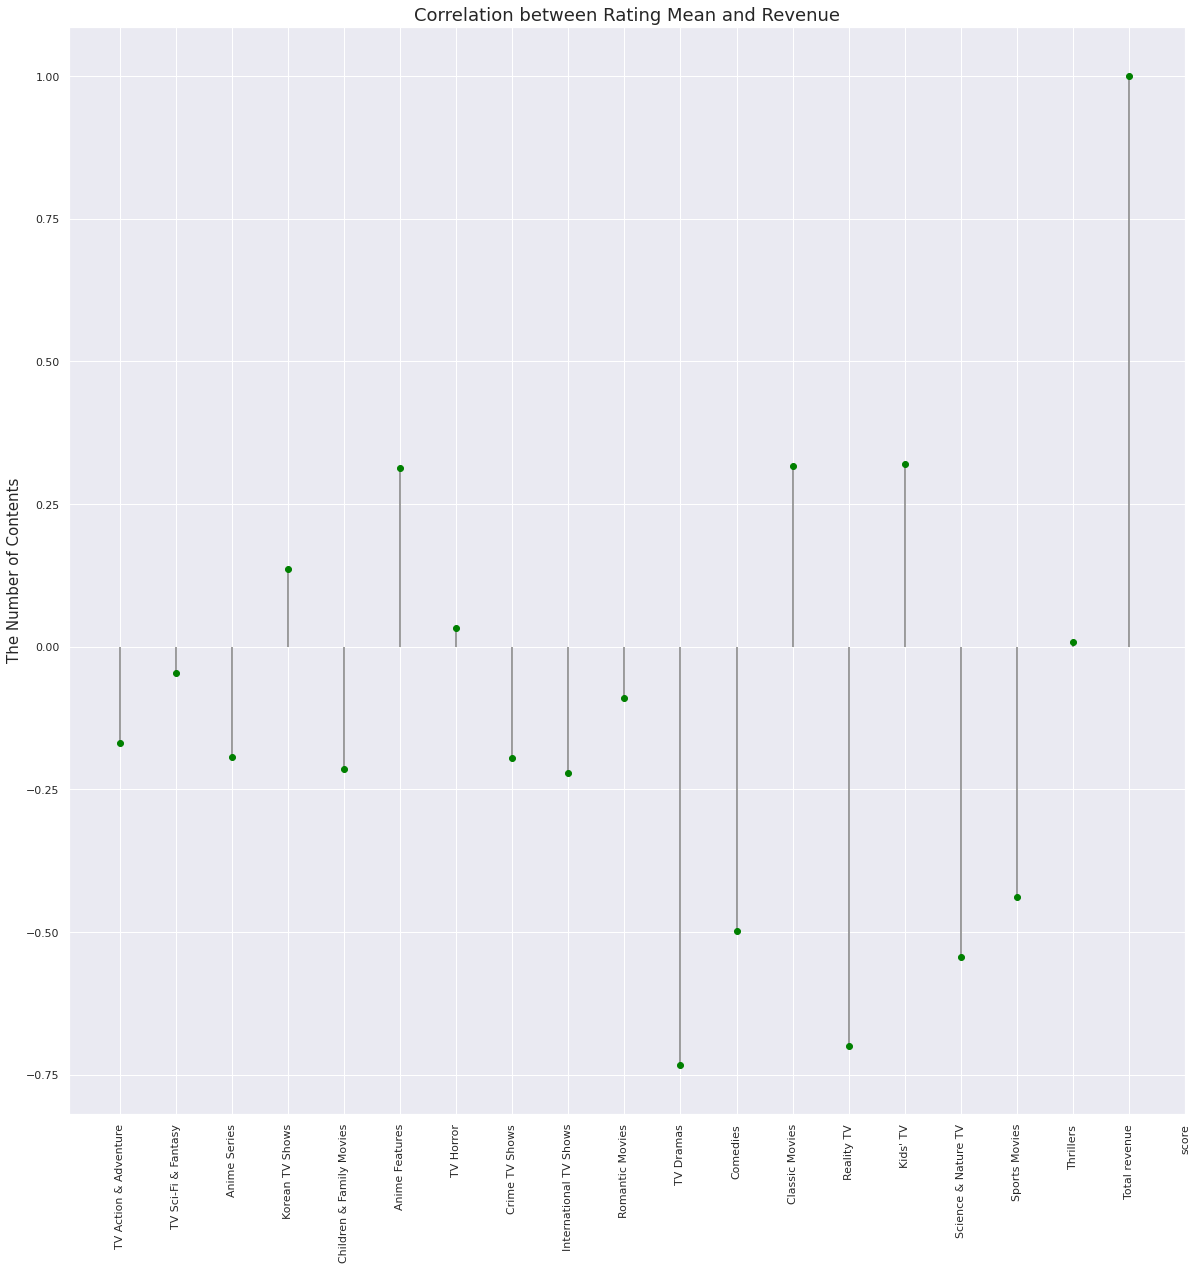

In [143]:
show_genre(genre_cor_dict, 'Correlation between Rating Mean and Revenue', 20, 20, 90)

In [144]:
ratings_of_genre[0]

score
                      title                           
TV Action & Adventure Dragons: Race to the Edge    4.3
                      Valor                        9.1
                      The Shannara Chronicles      3.6

수익과의 상관관계가 큰 컨텐츠일수록 평점이 높을 것이라 생각했지만 뚜렷한 특성을 보이지 않았다. 특정 장르의 특정 작품이 수익에 미친 영향을 알아보기 위해선 데이터를 모두 봐야하기 때문에, 그 방법보단 각 장르별 평점의 평균을 구해 수익성과의 관계를 파악하는 데에 이용했다. 다만 위의 결과를 보면 앞서 생각한 전제와는 다르게 별점 평균의 높낮이가 수익성에 큰 영향을 끼치진 않는 것으로 보인다.